In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from pmdarima import auto_arima
from ruptures import Binseg
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

> # Understanding The Data

In [108]:
data = pd.read_csv('../docs/Copy of BrentOilPrices.csv')
data.head()

Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63

In [109]:
data.tail()

Date  Price
9006  Nov 08, 2022  96.85
9007  Nov 09, 2022  93.05
9008  Nov 10, 2022  94.25
9009  Nov 11, 2022  96.37
9010  Nov 14, 2022  93.59

In [110]:
data.describe()

Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [112]:
print(f"minimum value = {data['Date'].min()}")
print(f"maximum value = {data['Date'].max()}")

minimum value = 01-Apr-02
maximum value = Sep 30, 2022


In [113]:
data.dtypes

Date      object
Price    float64
dtype: object

> # EDA

In [114]:
data.isna().sum()

Date     0
Price    0
dtype: int64

In [115]:
data['year'] = pd.to_datetime(data['Date']).dt.year
print(data['year'].head())

/tmp/ipykernel_4717/2467959993.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['year'] = pd.to_datetime(data['Date']).dt.year


0    1987
1    1987
2    1987
3    1987
4    1987
Name: year, dtype: int32


In [116]:
data['year'].describe()

count    9011.000000
mean     2004.612030
std        10.260414
min      1987.000000
25%      1996.000000
50%      2005.000000
75%      2014.000000
max      2022.000000
Name: year, dtype: float64

In [117]:
data[data['year']==2022].count()

Date     220
Price    220
year     220
dtype: int64

In [118]:
data['year'].isna().sum()

0

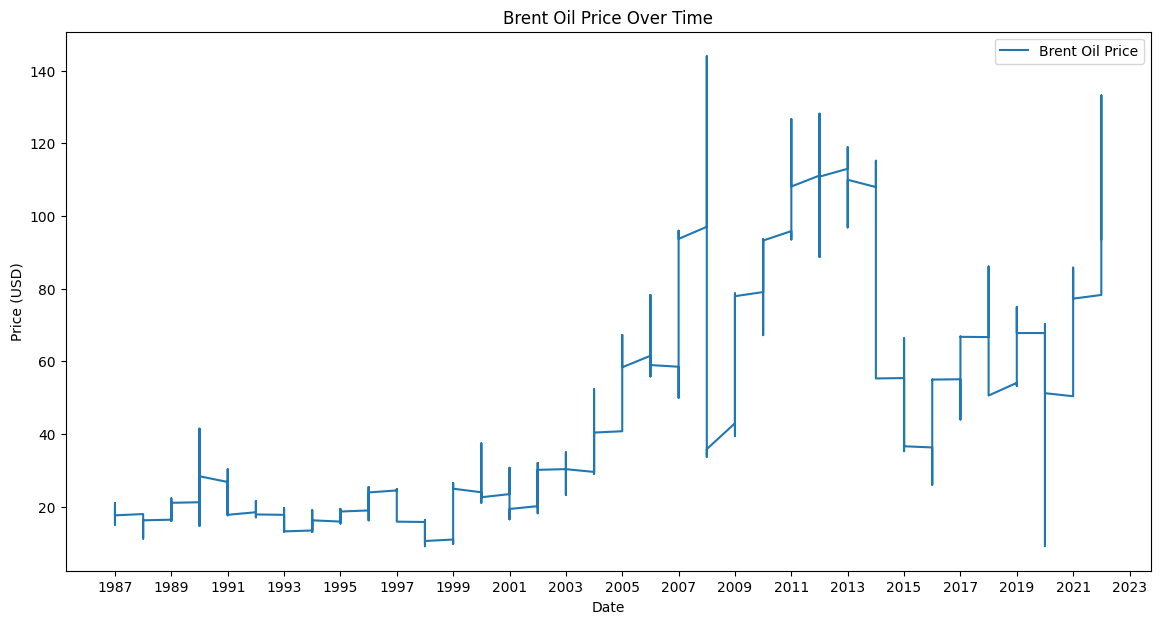

In [119]:
from scripts.plots import *
priceOverTime(data)

> # Change Point Analysis

/home/amanuel/Documents/Ten-Academy/week10/scripts/changePointAnalysis.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


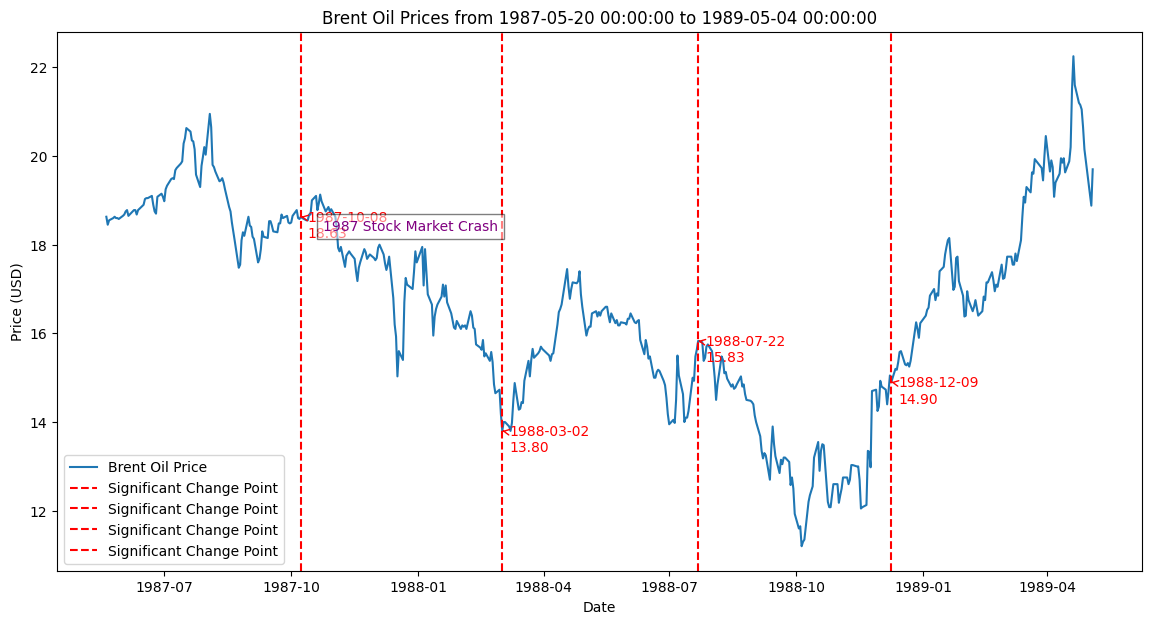

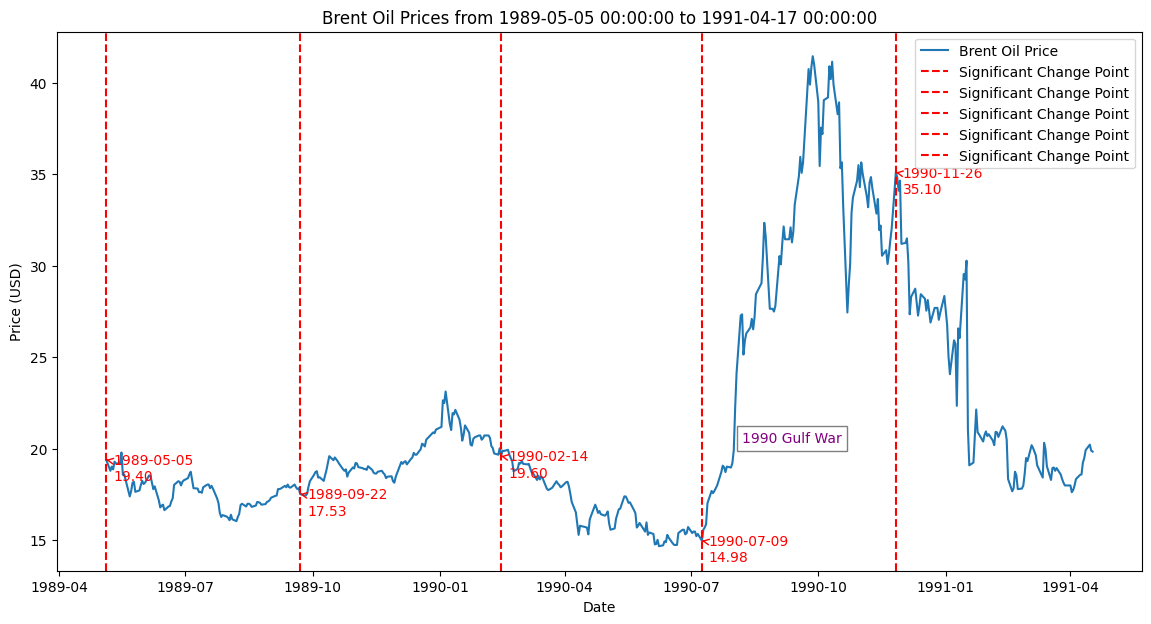

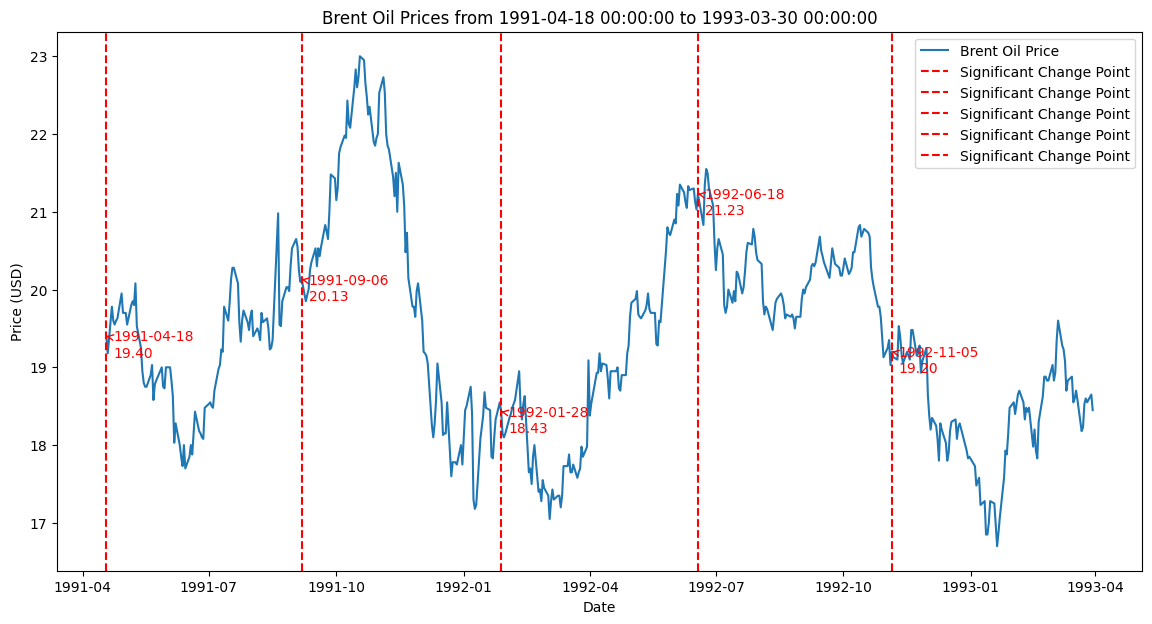

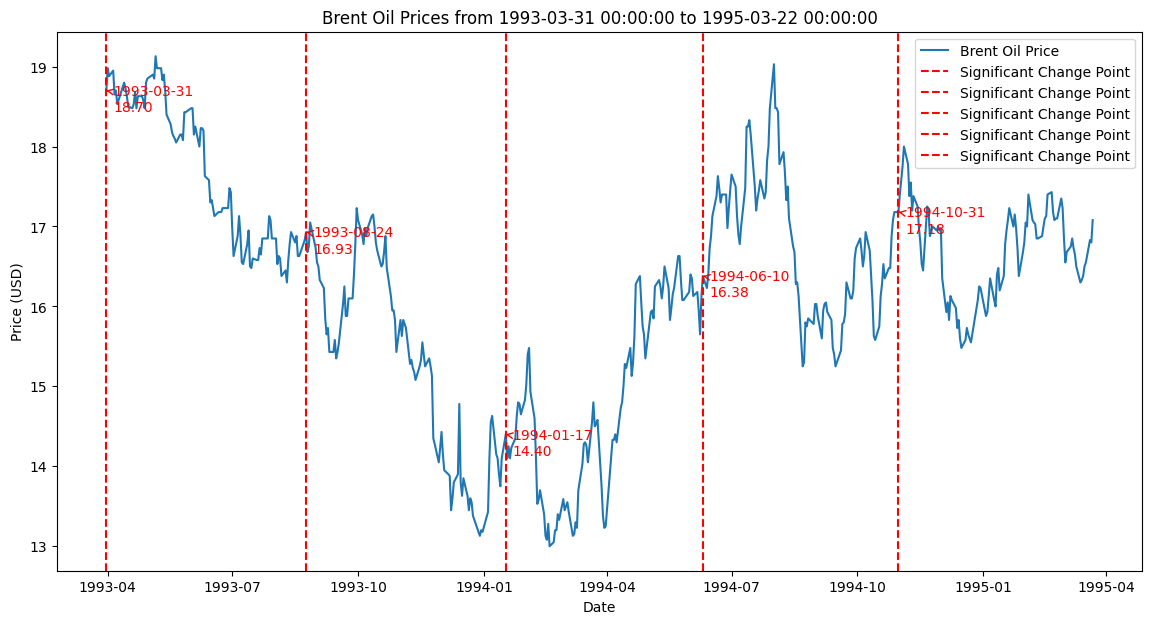

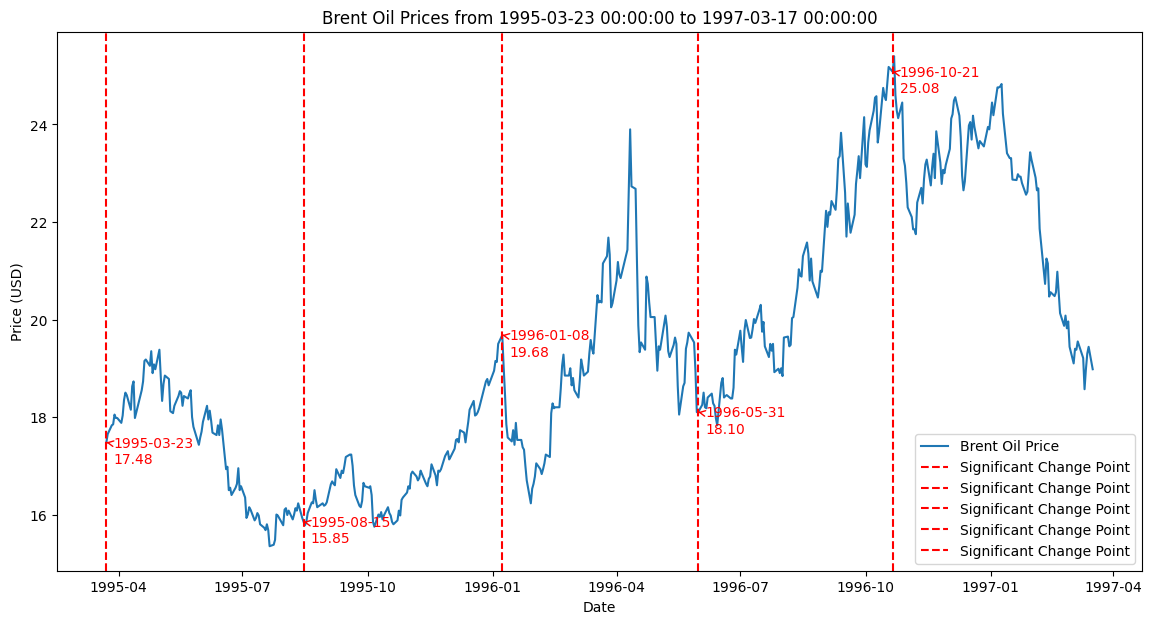

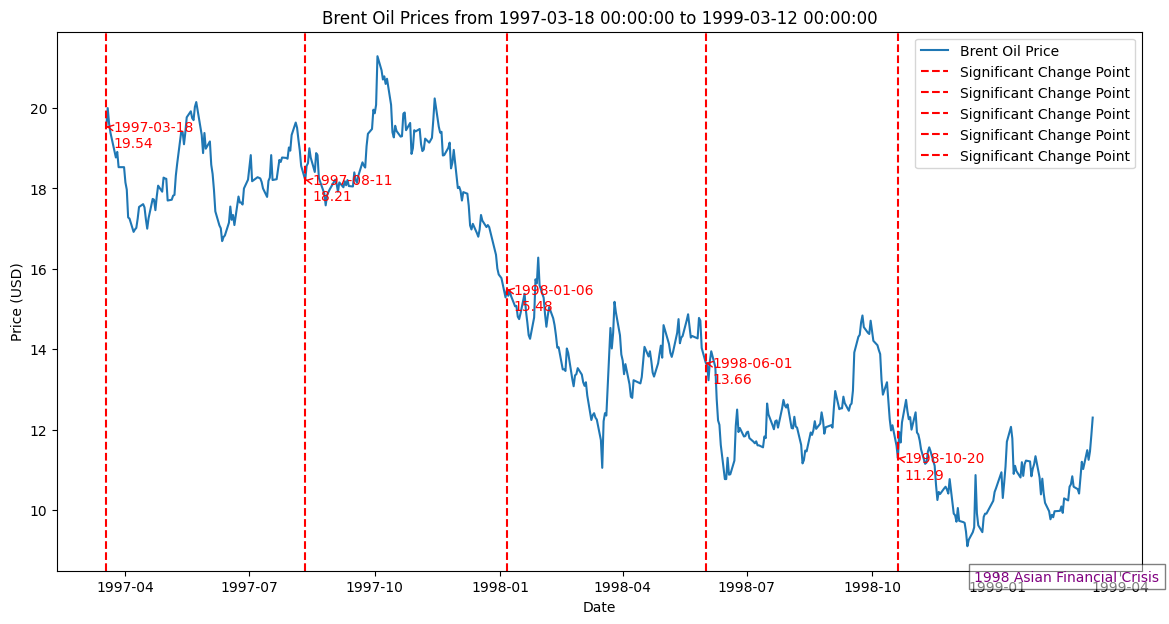

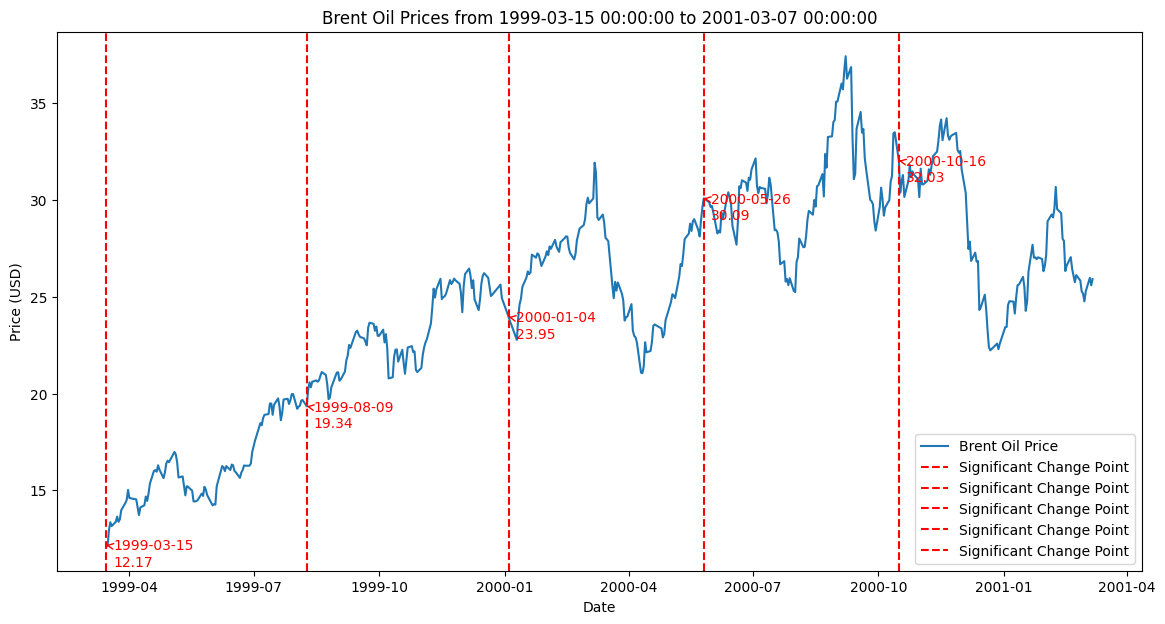

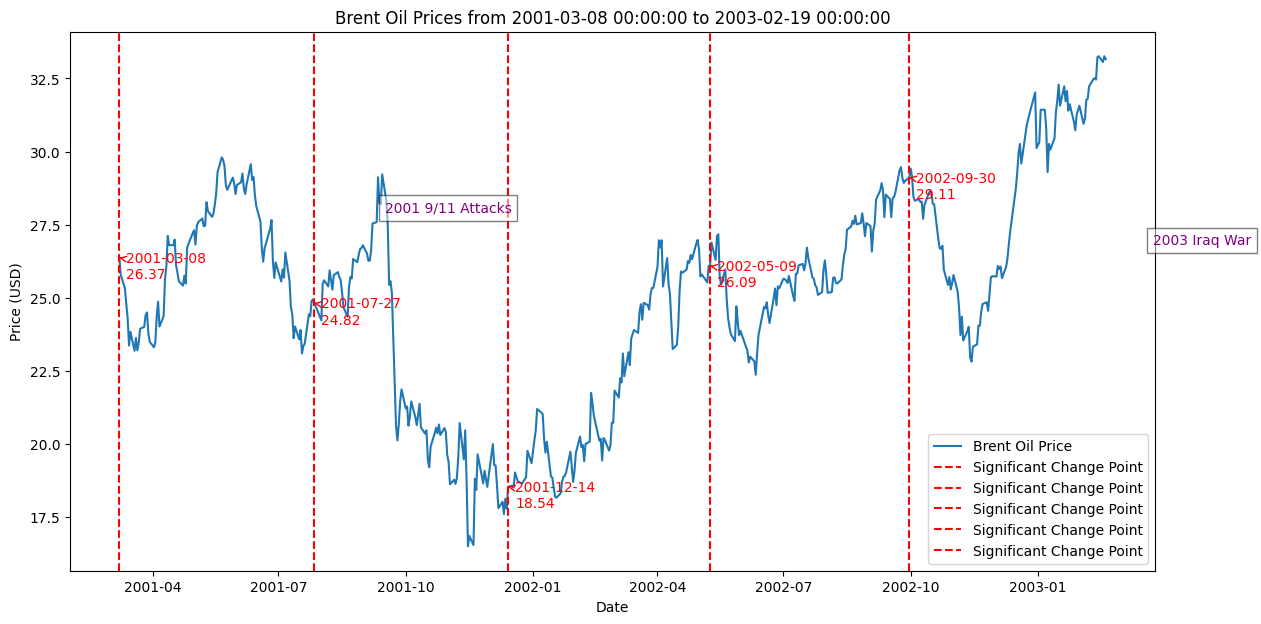

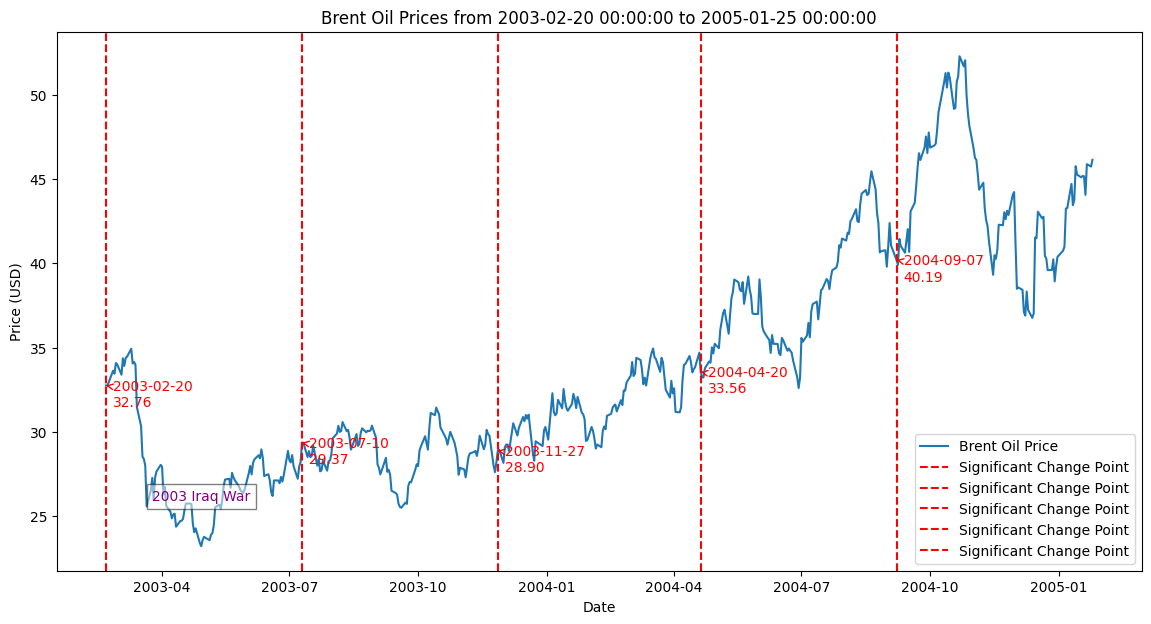

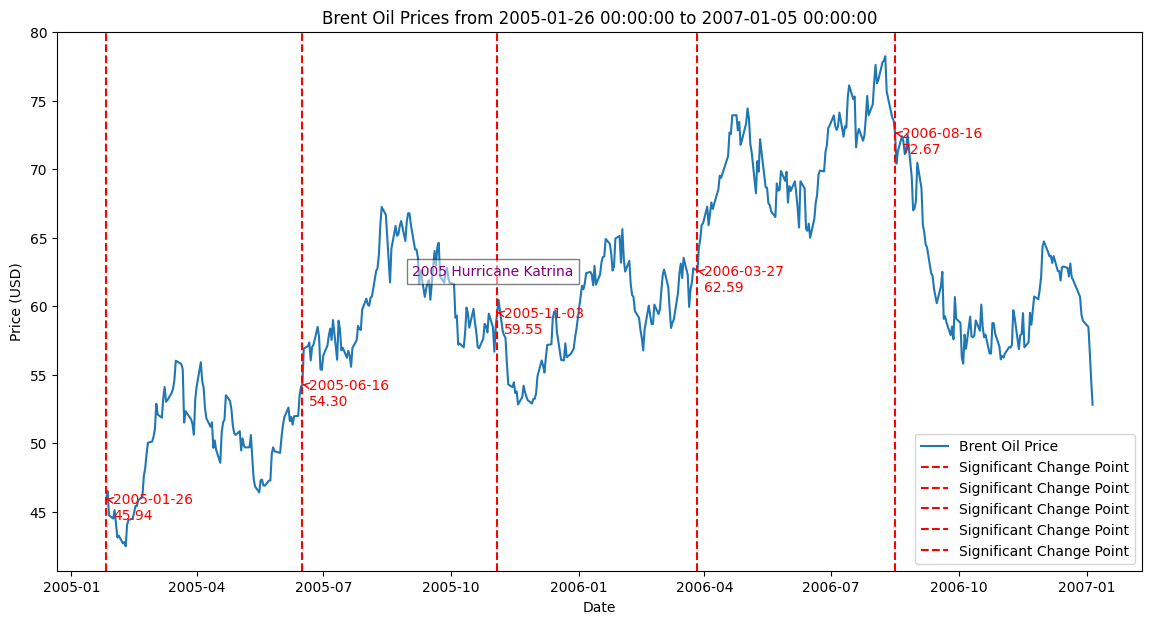

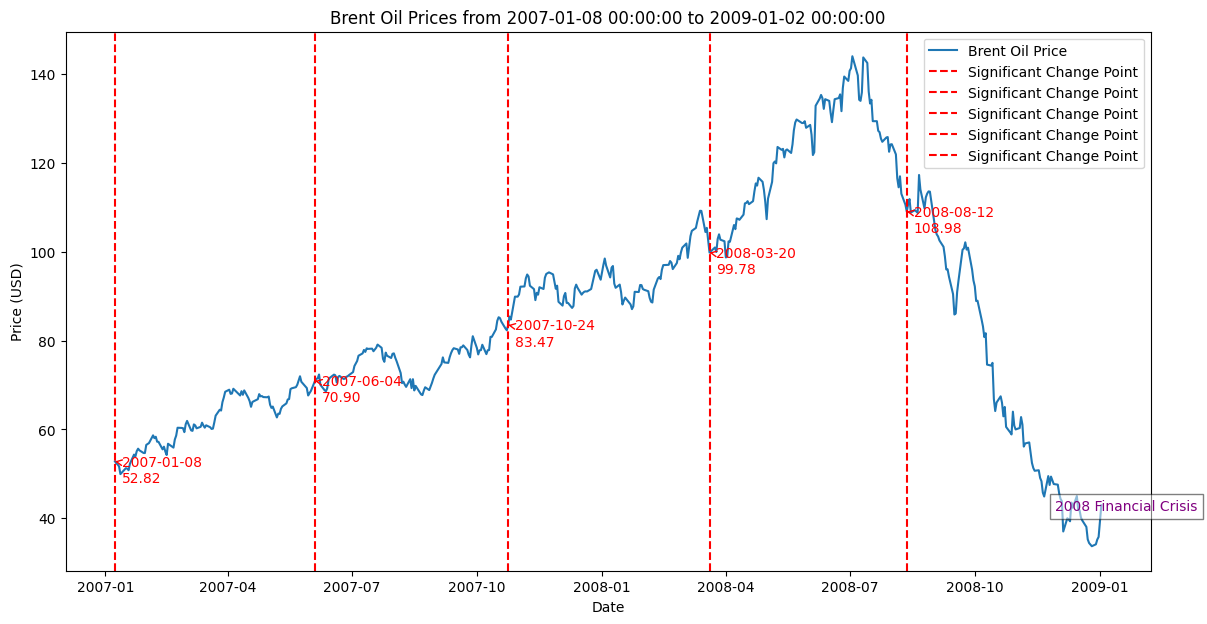

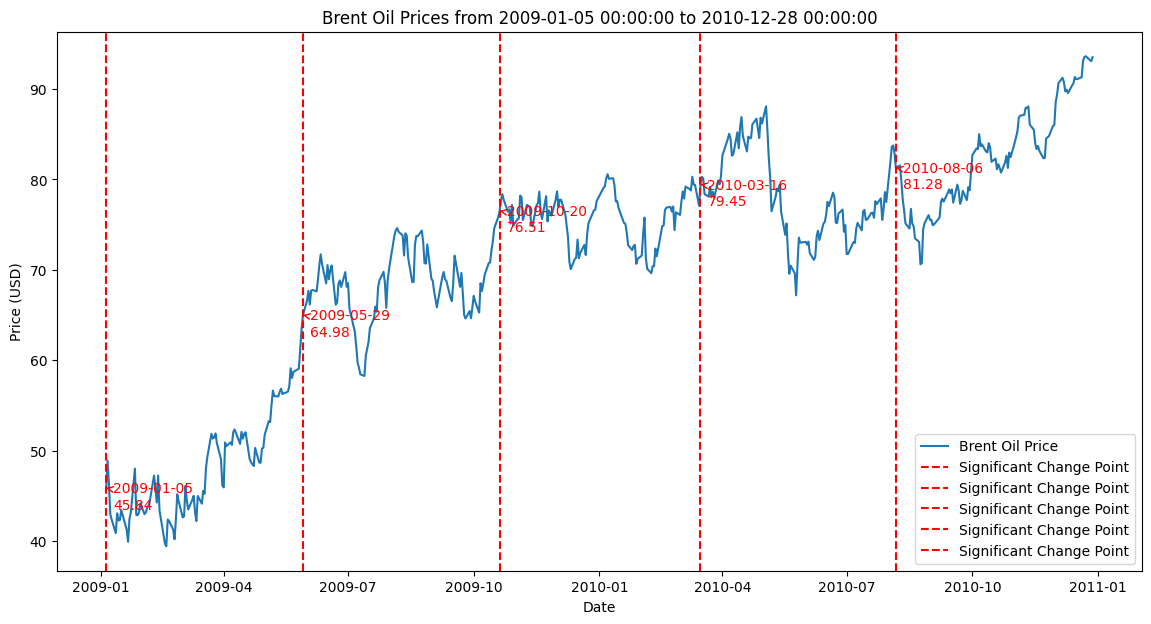

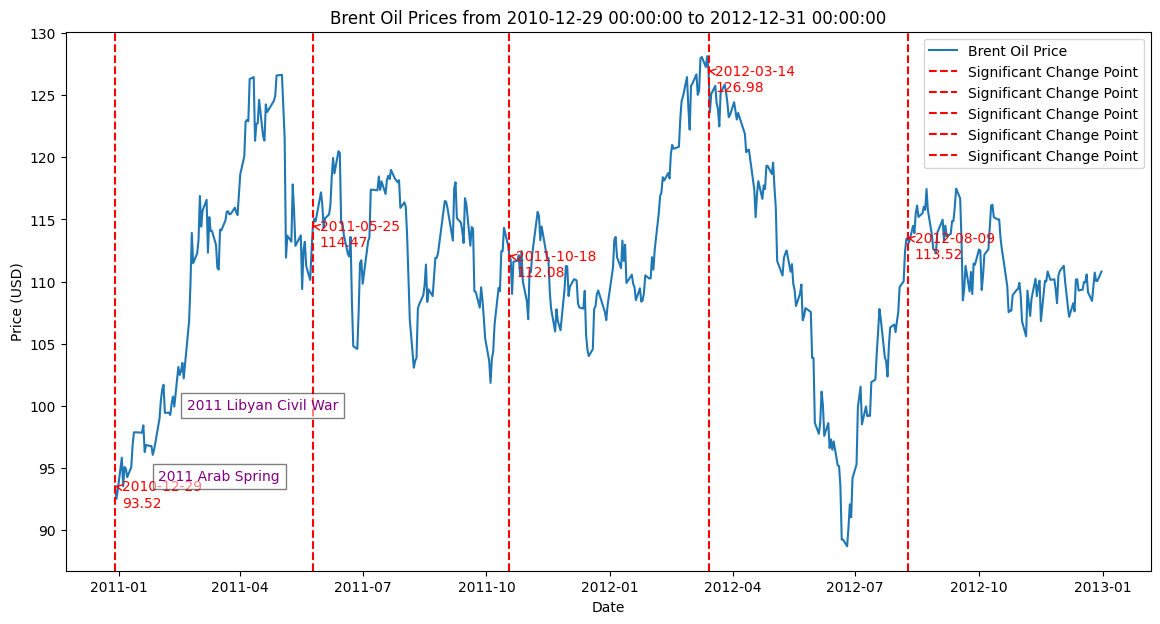

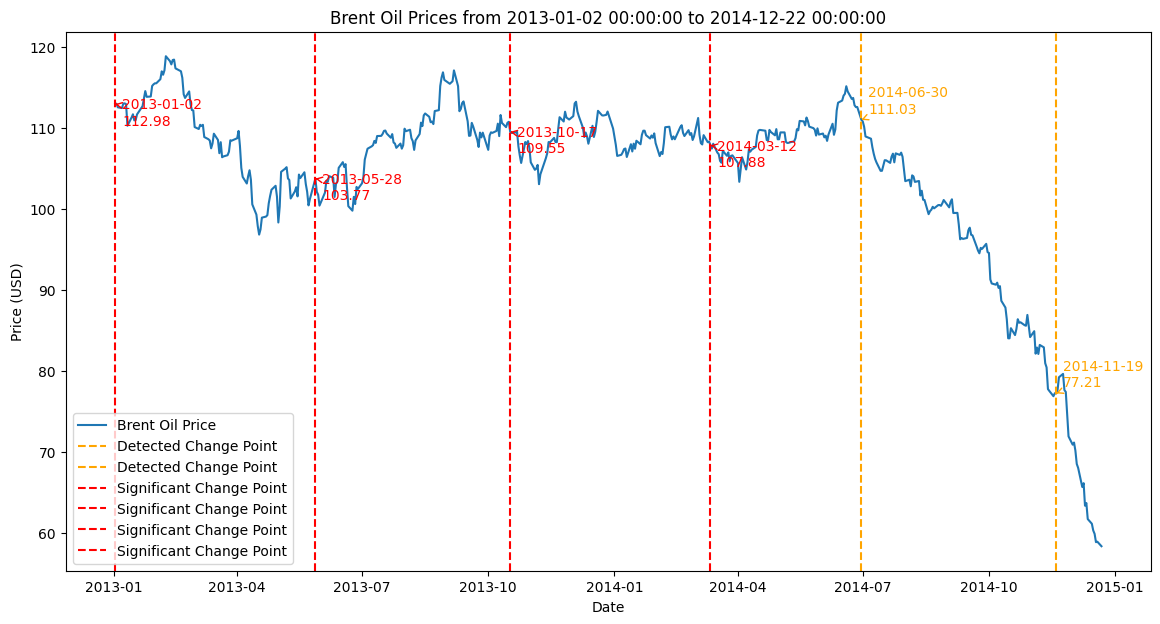

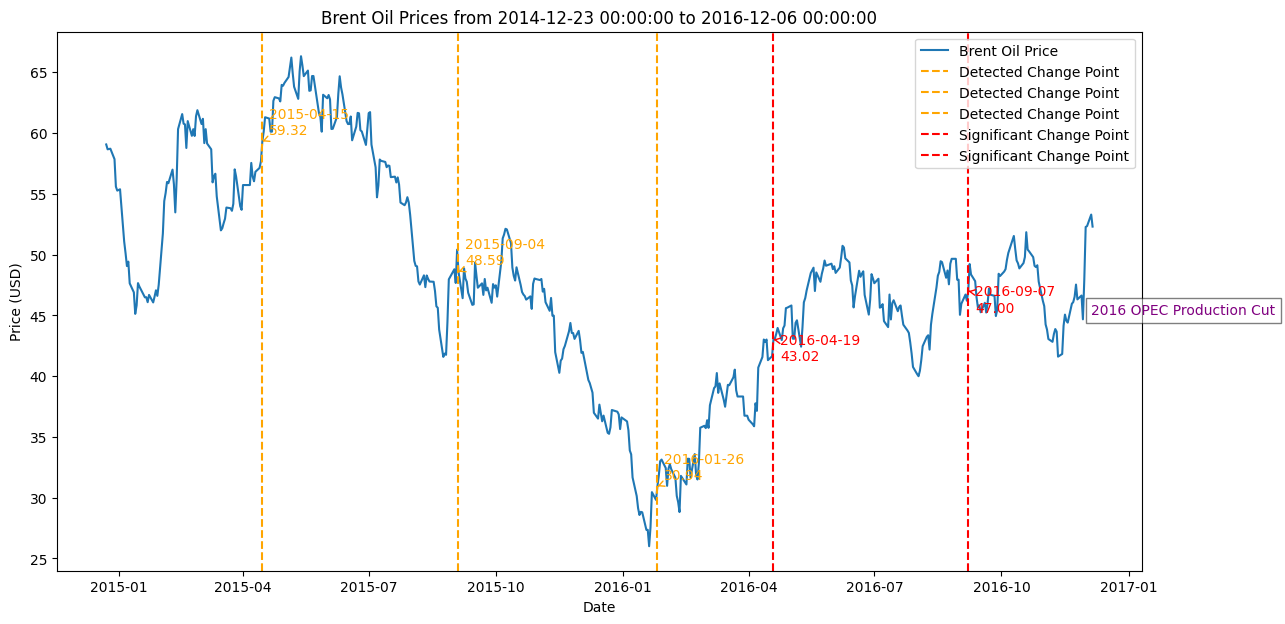

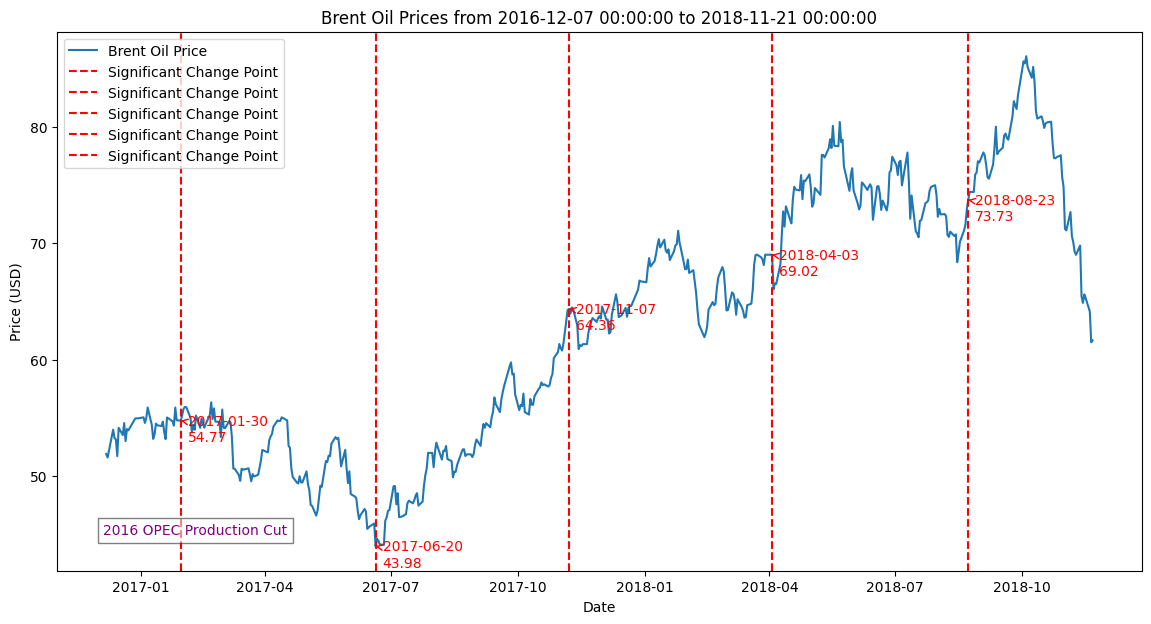

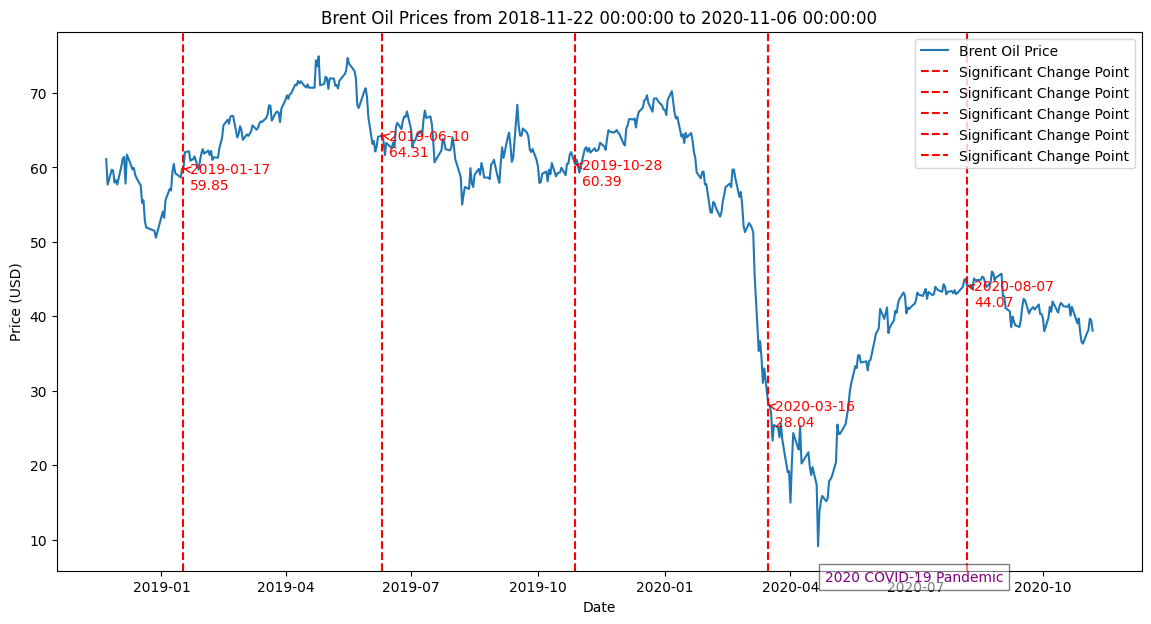

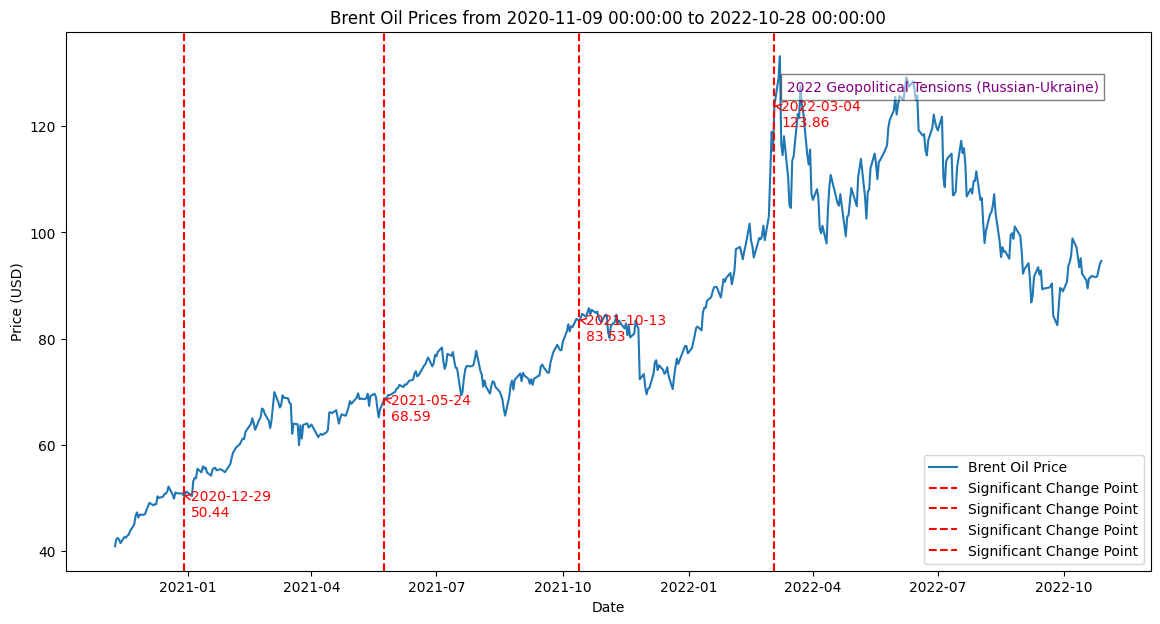

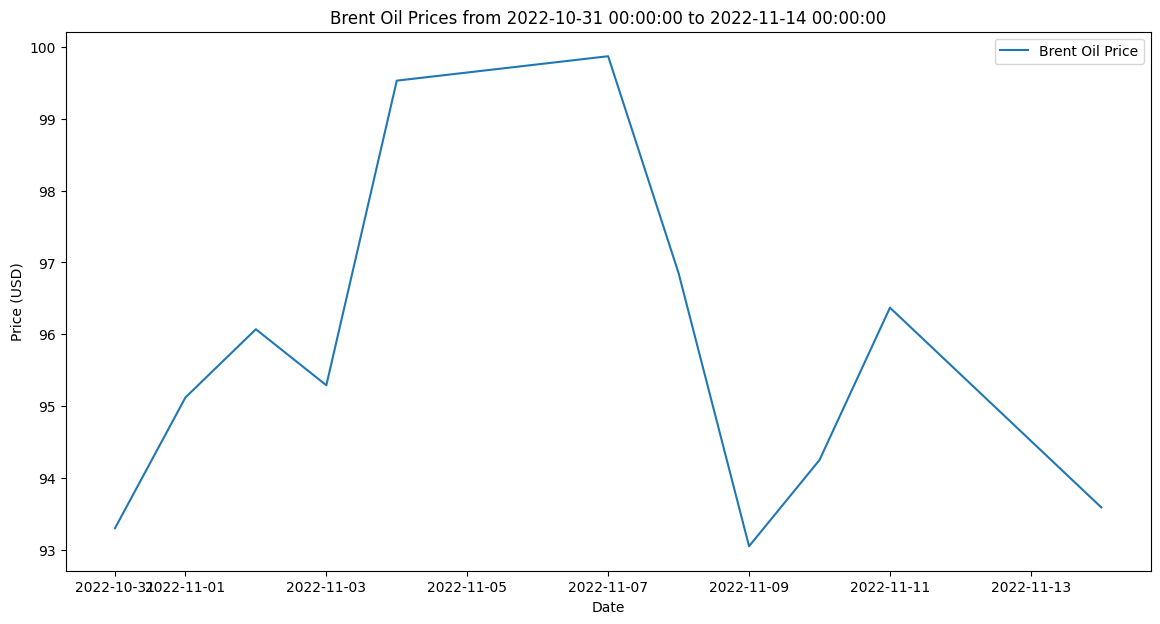

Detected Change Points and Significant Change Points have been saved to 'docs/change_points_results.csv'.


In [120]:
from scripts.changePointAnalysis import *
change_point_analysis(data)

>> ## Stationarity Test

In [121]:
adf_result = adfuller(data['Price'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    data['price_diff'] = data['Price'].diff().dropna()


ADF Statistic: -1.9938560113924666
p-value: 0.2892735048934033


>> ## ARIMA model trend analysis

/tmp/ipykernel_4717/292586442.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Price'] = df['Price'].fillna(method='ffill')
/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


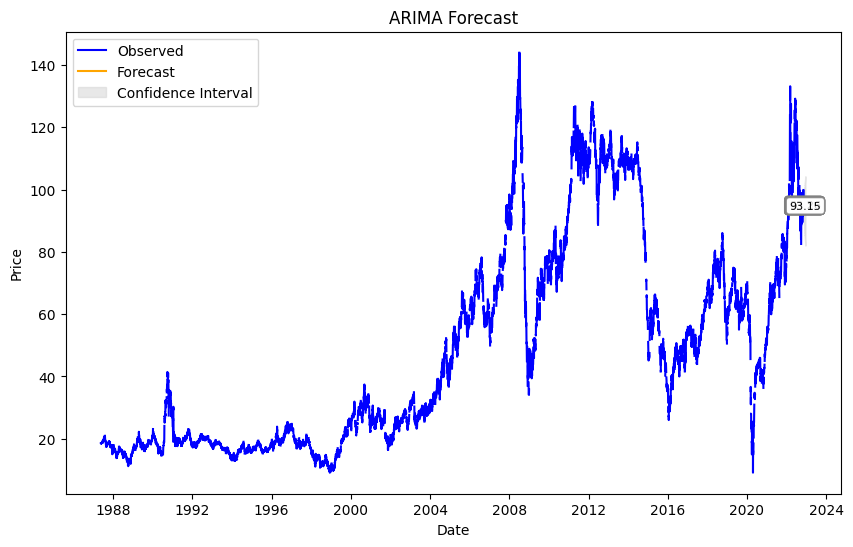

Forecasted Prices:

Date: 2022-11-15, Forecasted Price: 93.01
Date: 2022-11-16, Forecasted Price: 93.13
Date: 2022-11-17, Forecasted Price: 93.61
Date: 2022-11-18, Forecasted Price: 93.12
Date: 2022-11-19, Forecasted Price: 93.06
Date: 2022-11-20, Forecasted Price: 93.56
Date: 2022-11-21, Forecasted Price: 93.22
Date: 2022-11-22, Forecasted Price: 93.02
Date: 2022-11-23, Forecasted Price: 93.49
Date: 2022-11-24, Forecasted Price: 93.30
Date: 2022-11-25, Forecasted Price: 93.02
Date: 2022-11-26, Forecasted Price: 93.42
Date: 2022-11-27, Forecasted Price: 93.37
Date: 2022-11-28, Forecasted Price: 93.04
Date: 2022-11-29, Forecasted Price: 93.35
Date: 2022-11-30, Forecasted Price: 93.41
Date: 2022-12-01, Forecasted Price: 93.07
Date: 2022-12-02, Forecasted Price: 93.28
Date: 2022-12-03, Forecasted Price: 93.43
Date: 2022-12-04, Forecasted Price: 93.12
Date: 2022-12-05, Forecasted Price: 93.23
Date: 2022-12-06, Forecasted Price: 93.43
Date: 2022-12-07, Forecasted Price: 93.17
Date: 2022-12-

In [122]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load data
df = data.copy()

# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['Date'])
df = df.set_index('date')

# Ensure the index is a DatetimeIndex and set daily frequency if not set
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.DatetimeIndex(df.index)
df['Price'] = df['Price'].fillna(method='ffill')

# Set frequency to daily if not already inferred
if df.index.inferred_freq is None:
    df = df.asfreq('D') 

# Fit the ARIMA model
model = ARIMA(df['Price'], order=(3, 1, 2))
fitted_model = model.fit()

# Forecasting - Modify the periods as needed
forecast_steps = 30 
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Generate forecast and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')

# Confidence interval
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='lightgrey', alpha=0.5, label='Confidence Interval')

# Label forecast points on the chart
for date, price in zip(forecast_index, forecast_values):
    plt.text(
        date, price, f'{price:.2f}', ha='center', va='bottom', fontsize=8, color='black',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.8)
    )

plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print forecast values and dates below the chart
print("Forecasted Prices:\n")
for date, price in zip(forecast_index, forecast_values):
    print(f"Date: {date.strftime('%Y-%m-%d')}, Forecasted Price: {price:.2f}")


>> ## GARCH Model Volatility Analysis 

In [123]:
data.head()

Date  Price  year  price_diff
0 1987-05-20  18.63  1987         NaN
1 1987-05-21  18.45  1987       -0.18
2 1987-05-22  18.55  1987        0.10
3 1987-05-25  18.60  1987        0.05
4 1987-05-26  18.63  1987        0.03

In [124]:
data = data.fillna(18.63)
data.isna().sum()

Date          0
Price         0
year          0
price_diff    0
dtype: int64

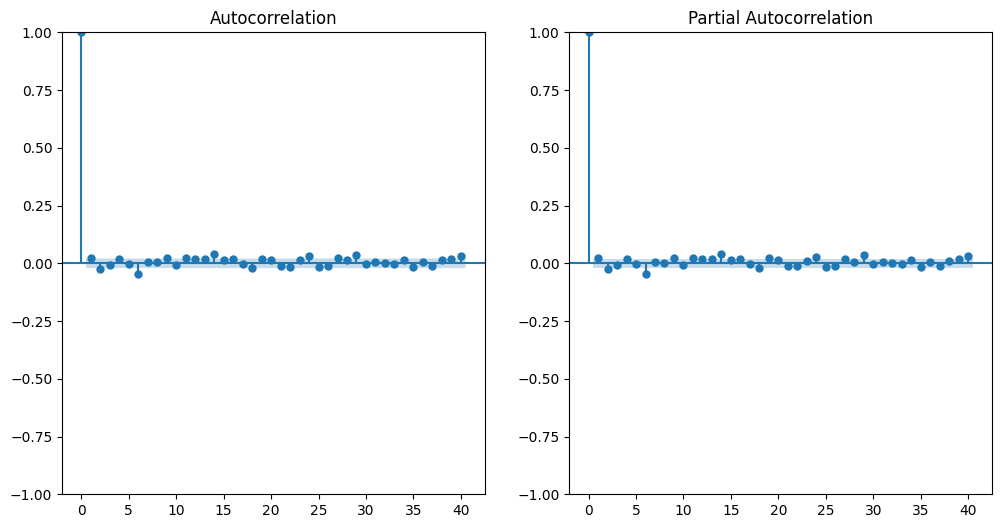

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(data['price_diff'], ax=ax[0])
plot_pacf(data['price_diff'], ax=ax[1])
plt.show()


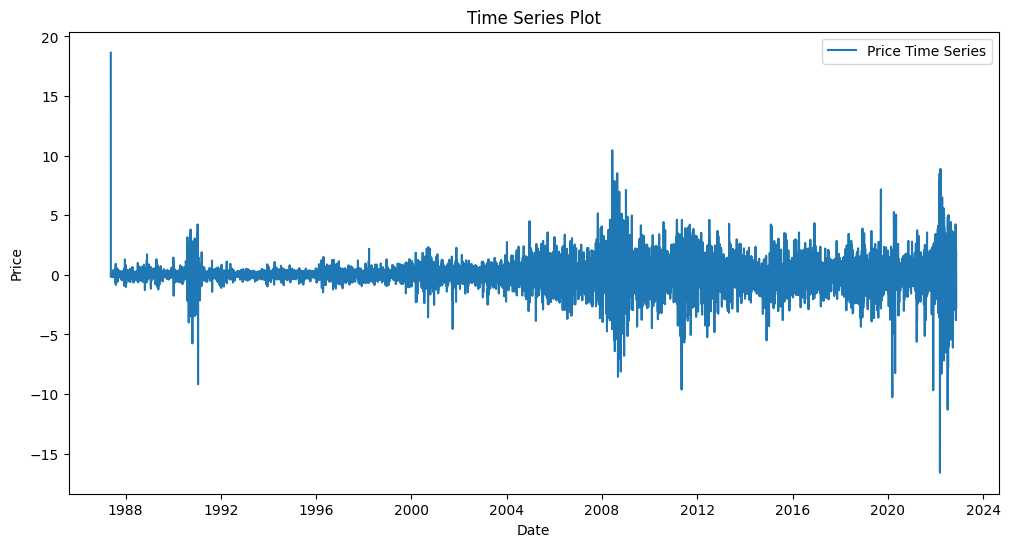

In [126]:
data = data.set_index('Date')
plt.figure(figsize=(12, 6))
plt.plot(data['price_diff'], label='Price Time Series')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
data = data.reset_index()

In [127]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming you've differenced your data and set d = 1
model = ARIMA(data['price_diff'], order=(1, 1, 1))  # Adjust p and q based on your findings
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14665.381
Date:                Mon, 04 Nov 2024   AIC                          29336.762
Time:                        23:29:41   BIC                          29358.081
Sample:                             0   HQIC                         29344.016
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0249      0.006      4.372      0.000       0.014       0.036
ma.L1         -1.0000      0.004   -259.656      0.000      -1.008      -0.992
sigma2         1.5163      0.010    151.132      0.0

In [128]:
adf_result = adfuller(data['price_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -15.55411557734697
p-value: 2.0820082417535323e-28


>> ## GARCH

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             price_diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10558.6
Distribution:                  Normal   AIC:                           21125.1
Method:            Maximum Likelihood   BIC:                           21153.6
                                        No. Observations:                 9010
Date:                Mon, Nov 04 2024   Df Residuals:                     9009
Time:                        23:29:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.8334e-03  4.990e-03      0.969      0.333 

/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


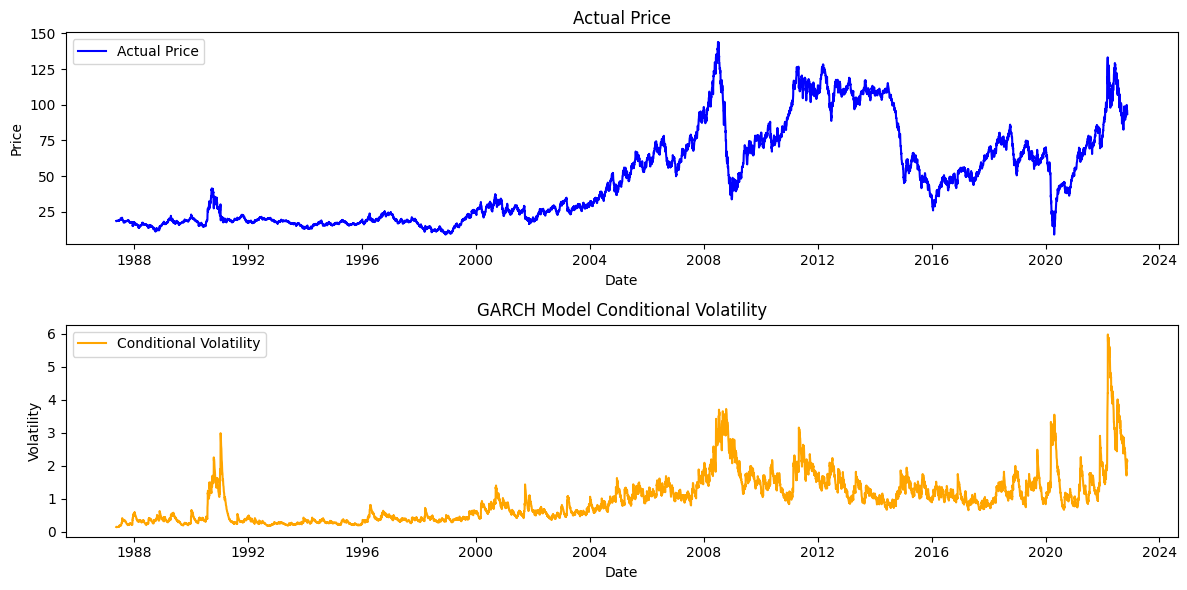

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'data' DataFrame is already defined and has a 'Price' column
# Ensure the 'date' column is set as the index
data['date'] = pd.to_datetime(data['Date'])  # Adjust 'Date' if necessary
data.set_index('date', inplace=True)

# Calculate the price difference
data['price_diff'] = data['Price'].diff().dropna()

# Fit GARCH model to the price differences
garch_model = arch_model(data['price_diff'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Print the summary of the GARCH model
print(garch_fit.summary())

# Get the index for the price_diff series
price_diff_index = data.index[1:]  # Exclude the first index since it corresponds to NaN after differencing

# Plot the actual price and the conditional volatility
plt.figure(figsize=(12, 6))

# Plot actual price
plt.subplot(2, 1, 1)
plt.plot(data['Price'], color='blue', label='Actual Price')
plt.title('Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot conditional volatility
plt.subplot(2, 1, 2)
plt.plot(price_diff_index, garch_fit.conditional_volatility, color='orange', label='Conditional Volatility')
plt.title('GARCH Model Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

>> ## With ARIMA

/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                 9010
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14543.748
Date:                Mon, 04 Nov 2024   AIC                          29095.496
Time:                        23:29:42   BIC                          29123.920
Sample:                             0   HQIC                         29105.168
                               - 9010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.013      0.625      0.532      -0.018       0.034
ar.L1         -0.3416      0.160     -2.139      0.032      -0.655      -0.029
ma.L1          0.3701      0.15

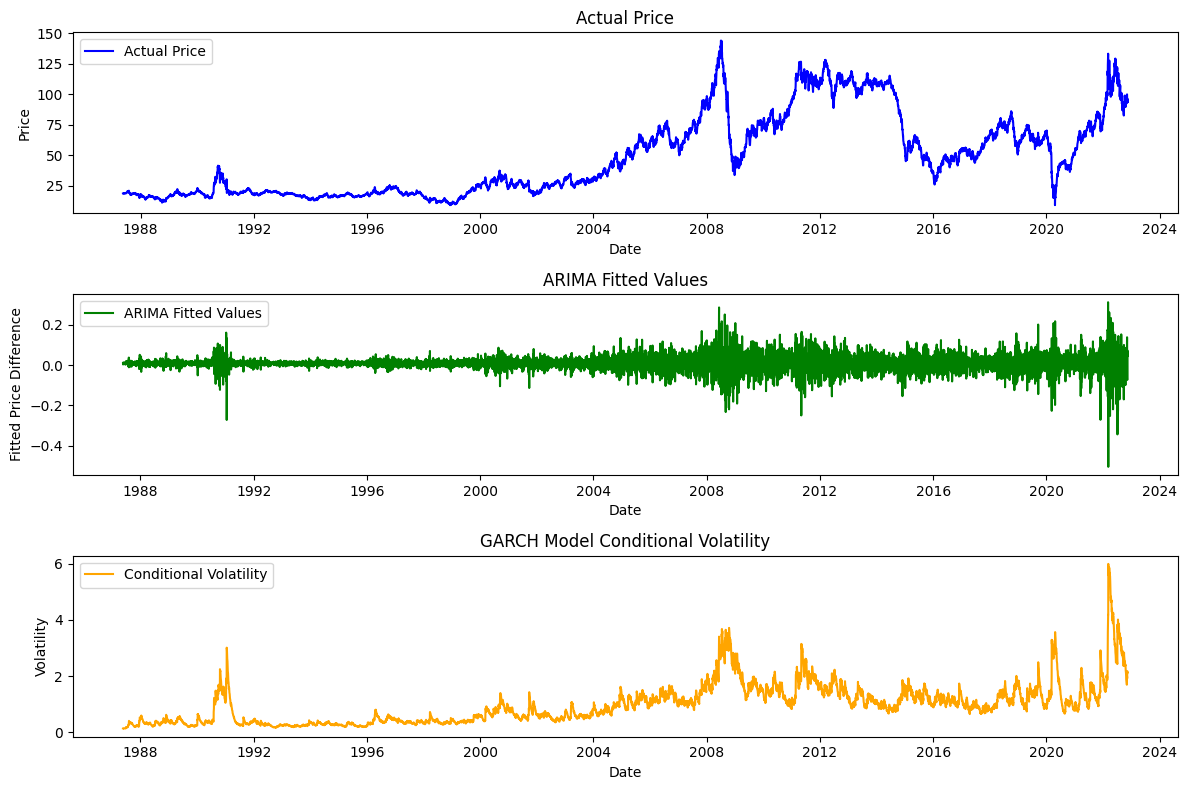

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Assuming 'data' DataFrame is already defined and has a 'Price' column
# Ensure the 'date' column is set as the index
data['date'] = pd.to_datetime(data['Date'])  # Adjust 'Date' if necessary
data.set_index('date', inplace=True)

# Calculate the price difference
data['price_diff'] = data['Price'].diff().dropna()

# Fit the ARIMA model to the price differences
arima_model = ARIMA(data['price_diff'].dropna(), order=(1, 0, 1))  # d=0 since price_diff is already differenced
fitted_arima = arima_model.fit()

# Print the summary of the ARIMA model
print("ARIMA Model Summary:")
print(fitted_arima.summary())

# Get the residuals from the ARIMA model
arima_residuals = fitted_arima.resid

# Fit the GARCH model to the ARIMA residuals
garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Print the summary of the GARCH model
print("GARCH Model Summary:")
print(garch_fit.summary())

# Generate ARIMA fitted values
arima_fitted_values = fitted_arima.fittedvalues

# Prepare the index for plotting
price_diff_index = data.index[1:]  # Exclude the first index since it corresponds to NaN after differencing

# Plot the actual price, ARIMA fitted values, and GARCH conditional volatility
plt.figure(figsize=(12, 8))

# Plot actual price
plt.subplot(3, 1, 1)
plt.plot(data['Price'], color='blue', label='Actual Price')
plt.title('Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot ARIMA fitted values
plt.subplot(3, 1, 2)
plt.plot(price_diff_index, arima_fitted_values, color='green', label='ARIMA Fitted Values')
plt.title('ARIMA Fitted Values')
plt.xlabel('Date')
plt.ylabel('Fitted Price Difference')
plt.legend()

# Plot conditional volatility from GARCH model
plt.subplot(3, 1, 3)
plt.plot(price_diff_index, garch_fit.conditional_volatility, color='orange', label='Conditional Volatility')
plt.title('GARCH Model Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

>> ## LSTM Model for short term forecasting

In [131]:
OG_data = data.copy()

Epoch 1/10


/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0302
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0020
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0021
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0023
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0022
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0022
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0023
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0021
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0024
Epoch 10/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0022
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


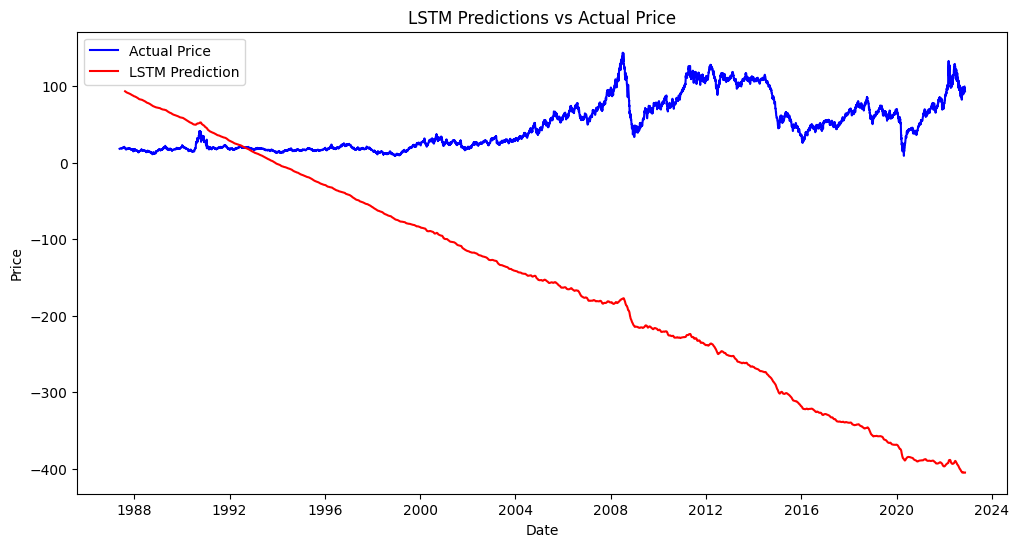

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming 'data' DataFrame is already defined and has a 'Price' column
data['date'] = pd.to_datetime(data['Date'])  # Adjust 'Date' if necessary
data.set_index('date', inplace=True)

# Calculate the price difference and drop NaNs
data['price_diff'] = data['Price'].diff().dropna()
data = data.dropna()  # Drop NaN values from the DataFrame

# Scale the price difference data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['price_diff'].values.reshape(-1, 1))

# Prepare the dataset for LSTM
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model with more epochs
model.fit(X, y, epochs=10, batch_size=32)

# Generate predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Convert predictions back to price levels
last_price = data['Price'].iloc[-1]  # Get the last actual price
predicted_prices = last_price + predictions.cumsum(axis=0)  # Cumulative sum of predicted changes

# Prepare for plotting
predicted_index = data.index[sequence_length:len(predicted_prices) + sequence_length]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Actual Price', color='blue')
plt.plot(predicted_index, predicted_prices, color='red', label='LSTM Prediction')
plt.title('LSTM Predictions vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

>> ## Get data

>>> ### GDP

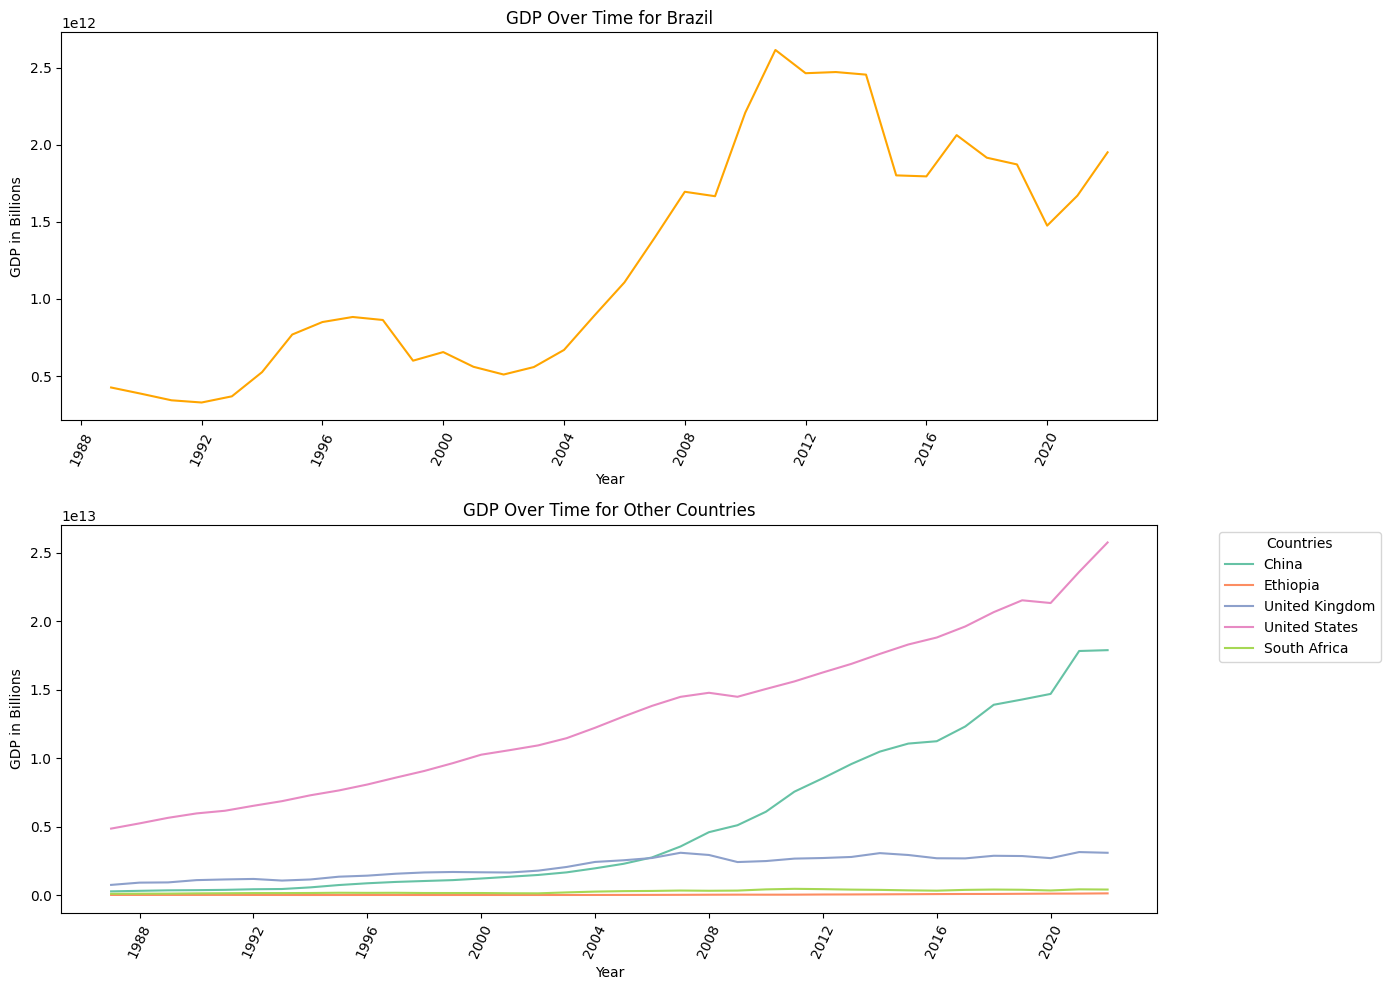

In [133]:
import pandas as pd
import wbdata
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set the date range for your analysis
start_date = datetime.datetime(1987, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

countries = ['USA', 'ETH', 'GBR', 'ZAF', 'BRA', 'CHN'] 

# Fetch GDP data for the countries
gdp_data = wbdata.get_dataframe({'NY.GDP.MKTP.CD': 'GDP'}, country=countries)
gdp_data.reset_index(inplace=True)

# Convert 'date' column to datetime
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

# Filter the GDP data to only include data from 1987 onwards
gdp_data = gdp_data[(gdp_data['date'] >= start_date) & (gdp_data['date'] <= end_date)]

# Split the data for Brazil and the other countries
brazil_gdp = gdp_data[gdp_data['country'] == 'Brazil']
other_gdp = gdp_data[gdp_data['country'] != 'Brazil']

# Set up the figure and axes for the subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Plotting GDP for Brazil
sns.lineplot(data=brazil_gdp, x='date', y='GDP', color='orange', ax=axs[0])
axs[0].set_title('GDP Over Time for Brazil')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('GDP in Billions')
axs[0].tick_params(axis='x', rotation=65)  

# Plotting GDP for other countries
sns.lineplot(data=other_gdp, x='date', y='GDP', hue='country', palette='Set2', ax=axs[1])
axs[1].set_title('GDP Over Time for Other Countries')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('GDP in Billions')
axs[1].tick_params(axis='x', rotation=65)  
axs[1].legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

>>> ### Inflation

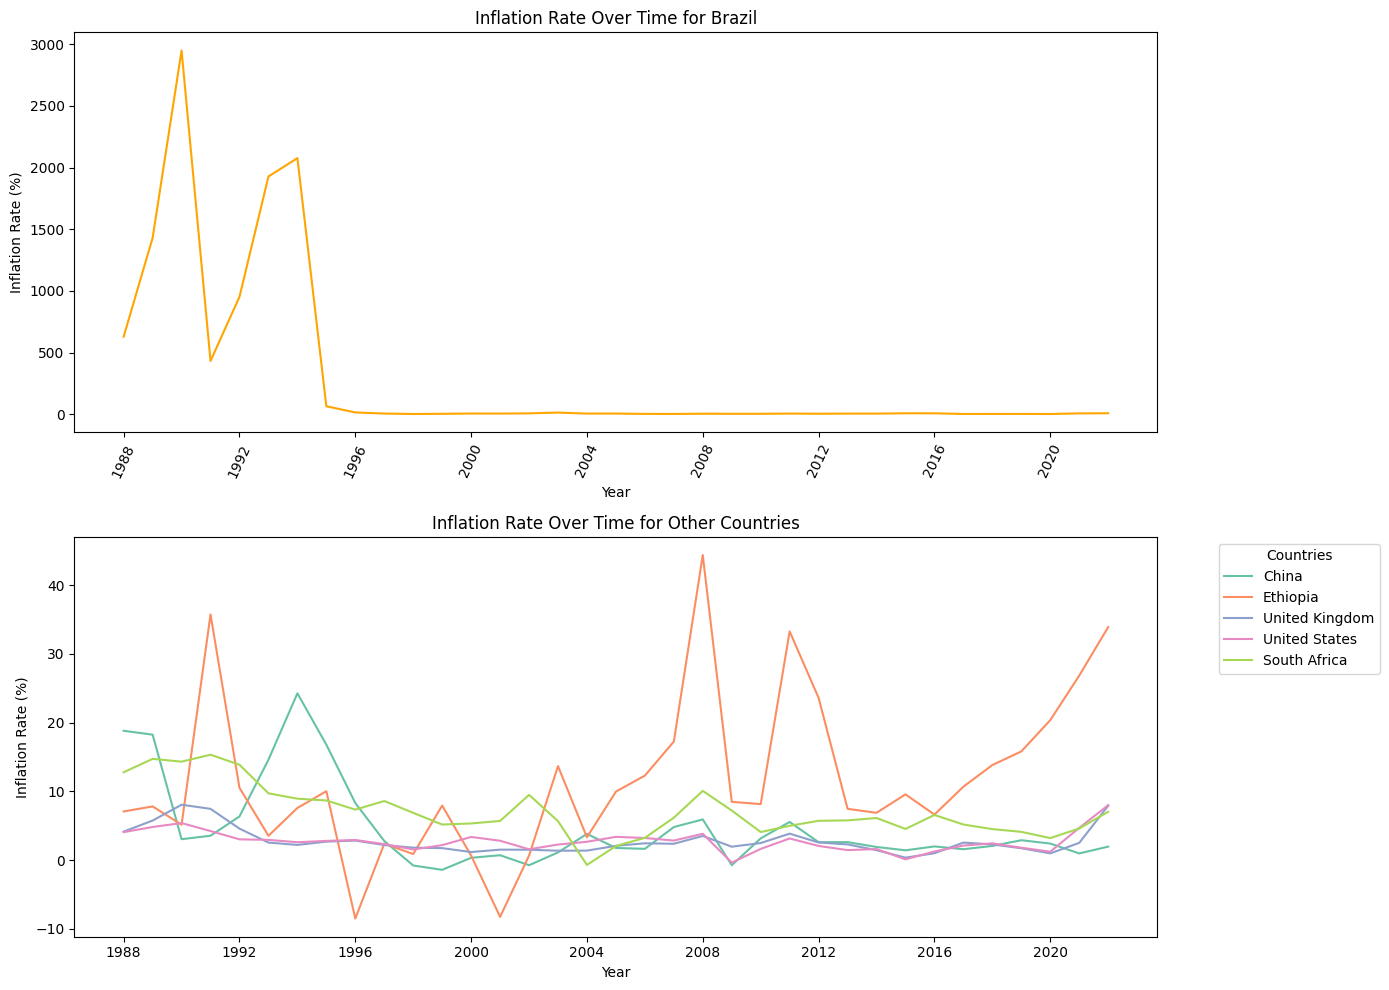

In [134]:
# Set the date range for analysis
start_date = datetime.datetime(1987,5,20)
end_date = datetime.datetime(2022, 12, 31)

# Fetch Inflation data (Consumer Prices, Annual %)
inflation_data = wbdata.get_dataframe({'FP.CPI.TOTL.ZG': 'Inflation'}, country=countries)
inflation_data.reset_index(inplace=True)

# Convert 'date' column to datetime and filter for 1987–2022
inflation_data['date'] = pd.to_datetime(inflation_data['date'])
inflation_data = inflation_data[(inflation_data['date'] >= start_date) & (inflation_data['date'] <= end_date)]

# Display the Inflation data
brazil_inflation = inflation_data[inflation_data['country'] == 'Brazil']
other_inflation = inflation_data[inflation_data['country'] != 'Brazil']

# Set up the figure and axes for the subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Plotting Inflation for Brazil
sns.lineplot(data=brazil_inflation, x='date', y='Inflation', color='orange', ax=axs[0])
axs[0].set_title('Inflation Rate Over Time for Brazil')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Inflation Rate (%)')
axs[0].tick_params(axis='x', rotation=65)  # Rotate x ticks for Brazil

# Plotting Inflation for other countries
sns.lineplot(data=other_inflation, x='date', y='Inflation', hue='country', palette='Set2', ax=axs[1])
axs[1].set_title('Inflation Rate Over Time for Other Countries')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Inflation Rate (%)')
axs[1].legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


>>> ### Unemployement rates

Unemployment Data:
          country       date  Unemployment
1          Brazil 2022-01-01         9.231
2          Brazil 2021-01-01        13.159
3          Brazil 2020-01-01        13.697
4          Brazil 2019-01-01        11.936
5          Brazil 2018-01-01        12.330
..            ...        ...           ...
351  South Africa 1992-01-01        20.369
352  South Africa 1991-01-01        20.105
353  South Africa 1990-01-01           NaN
354  South Africa 1989-01-01           NaN
355  South Africa 1988-01-01           NaN

[210 rows x 3 columns]


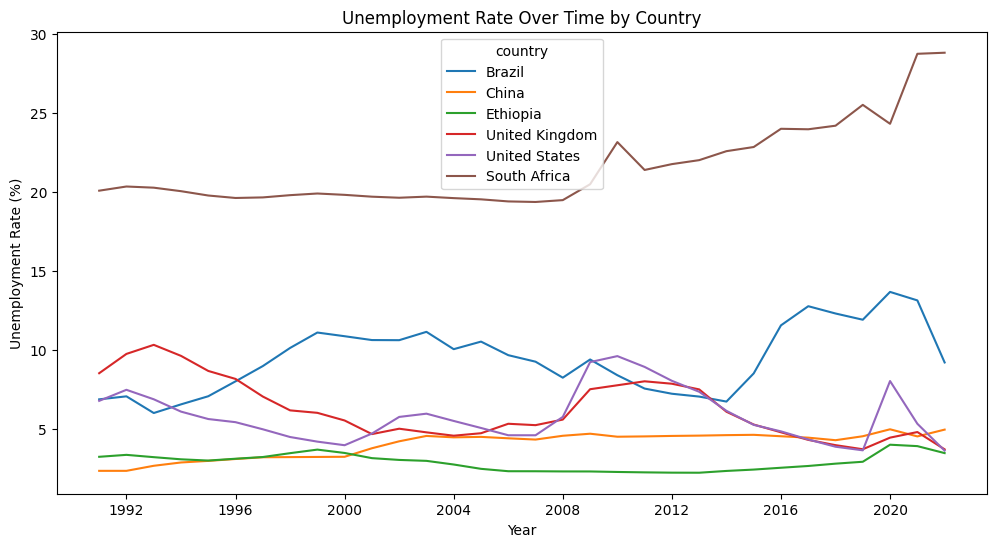

In [135]:
# Fetch Unemployment data (Total Unemployment, % of total labor force)
unemployment_data = wbdata.get_dataframe({'SL.UEM.TOTL.ZS': 'Unemployment'}, country=countries)
unemployment_data.reset_index(inplace=True)

# Convert 'date' column to datetime and filter for 1987–2022
unemployment_data['date'] = pd.to_datetime(unemployment_data['date'])
unemployment_data = unemployment_data[(unemployment_data['date'] >= start_date) & (unemployment_data['date'] <= end_date)]

# Display the Unemployment data
print("Unemployment Data:")
print(unemployment_data)

# Plotting Unemployment data
plt.figure(figsize=(12, 6))
sns.lineplot(data=unemployment_data, x='date', y='Unemployment', hue='country')
plt.title('Unemployment Rate Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.show()


>>> ### Exchange Rates

Exchange Rate Data:
          country       date  Exchange Rate
1          Brazil 2022-01-01       5.163970
2          Brazil 2021-01-01       5.394401
3          Brazil 2020-01-01       5.155179
4          Brazil 2019-01-01       3.944471
5          Brazil 2018-01-01       3.653825
..            ...        ...            ...
351  South Africa 1992-01-01       2.852014
352  South Africa 1991-01-01       2.761315
353  South Africa 1990-01-01       2.587321
354  South Africa 1989-01-01       2.622677
355  South Africa 1988-01-01       2.273468

[210 rows x 3 columns]


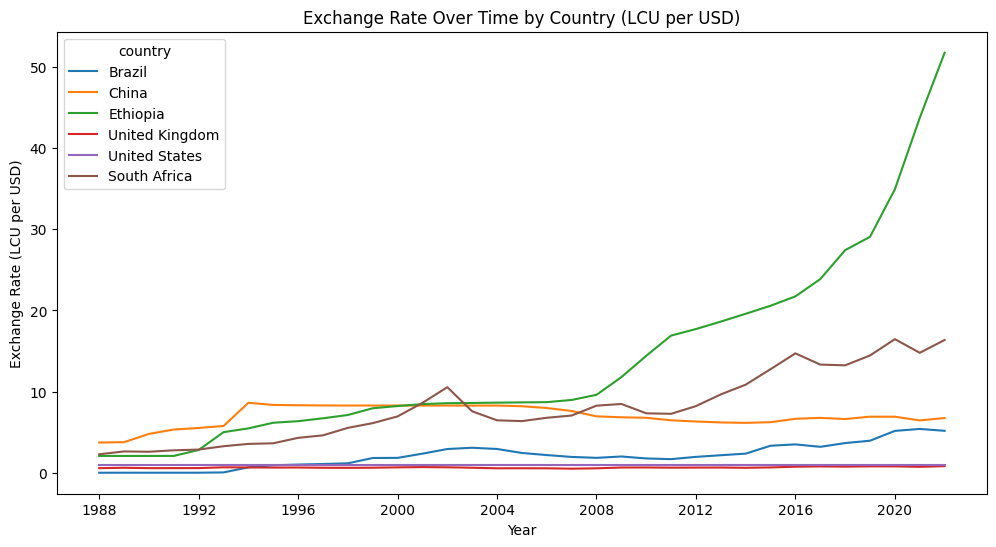

In [136]:
# Fetch Exchange Rate data (Exchange Rate, Official, LCU per USD)
exchange_rate_data = wbdata.get_dataframe({'PA.NUS.FCRF': 'Exchange Rate'}, country=countries)
exchange_rate_data.reset_index(inplace=True)

# Convert 'date' column to datetime and filter for 1987–2022
exchange_rate_data['date'] = pd.to_datetime(exchange_rate_data['date'])
exchange_rate_data = exchange_rate_data[(exchange_rate_data['date'] >= start_date) & (exchange_rate_data['date'] <= end_date)]

# Display the Exchange Rate data
print("Exchange Rate Data:")
print(exchange_rate_data)

# Plotting Exchange Rate data
plt.figure(figsize=(12, 6))
sns.lineplot(data=exchange_rate_data, x='date', y='Exchange Rate', hue='country')
plt.title('Exchange Rate Over Time by Country (LCU per USD)')
plt.xlabel('Year')
plt.ylabel('Exchange Rate (LCU per USD)')
plt.show()


>>> ### Combine them

In [137]:
data = data.reset_index()

In [138]:
data = data.drop(columns=['date'])
data.head()

Date  Price  year  price_diff
0 1987-05-21  18.45  1987       -0.18
1 1987-05-22  18.55  1987        0.10
2 1987-05-25  18.60  1987        0.05
3 1987-05-26  18.63  1987        0.03
4 1987-05-27  18.60  1987       -0.03

In [139]:
data_og = data.copy()

In [140]:
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year

gdp_data['date'] = pd.to_datetime(gdp_data['date'])
gdp_data['year'] = gdp_data['date'].dt.year

inflation_data['date'] = pd.to_datetime(inflation_data['date'])
inflation_data['year'] = inflation_data['date'].dt.year

unemployment_data['date'] = pd.to_datetime(unemployment_data['date'])
unemployment_data['year'] = unemployment_data['date'].dt.year

exchange_rate_data['date'] = pd.to_datetime(exchange_rate_data['date'])
exchange_rate_data['year'] = exchange_rate_data['date'].dt.year

# Step 2: Merge all datasets based on the 'year' column
# Start with the main 'data' DataFrame and merge progressively
combined_data = data.merge(gdp_data[['year', 'GDP']], on='year', how='left')
combined_data = combined_data.merge(inflation_data[['year', 'Inflation']], on='year', how='left')
combined_data = combined_data.merge(unemployment_data[['year', 'Unemployment']], on='year', how='left')
combined_data = combined_data.merge(exchange_rate_data[['year', 'Exchange Rate']], on='year', how='left')

# Step 3: Sort by 'Date' (not 'year') to ensure forward-filling is done in chronological order
combined_data = combined_data.sort_values(by='Date')

# Step 4: Forward-fill missing values for each economic indicator column
combined_data = combined_data.fillna(method='ffill')

# Step 5: Drop the extra 'year' column if it's no longer needed
combined_data = combined_data.drop(columns=['year'], errors='ignore')

# Step 6: Check the result
combined_data.head()

/tmp/ipykernel_4717/2354243472.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data = combined_data.fillna(method='ffill')


Date  Price  price_diff           GDP  Inflation  Unemployment  \
0 1987-05-21  18.45       -0.18           NaN        NaN           NaN   
1 1987-05-21  18.45       -0.18  2.729730e+11        NaN           NaN   
2 1987-05-21  18.45       -0.18  1.079000e+10        NaN           NaN   
3 1987-05-21  18.45       -0.18  7.451626e+11        NaN           NaN   
4 1987-05-21  18.45       -0.18  4.855215e+12        NaN           NaN   

   Exchange Rate  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [141]:
combined_data.isna().sum()

Date                  0
Price                 0
price_diff            0
GDP                   1
Inflation           954
Unemployment     992394
Exchange Rate       954
dtype: int64

In [142]:
row_count = combined_data.shape[0]

print("Number of rows before removing duplicates:", row_count)
combined_data = combined_data.drop_duplicates(subset='Date', keep='first')

row_count_after = combined_data.shape[0]

print("Number of rows after removing duplicates:", row_count_after)


Number of rows before removing duplicates: 11471850
Number of rows after removing duplicates: 9010


In [143]:
combined_data = combined_data.fillna(method='ffill')

for column in ['Inflation', 'Unemployment', 'Exchange Rate']:
    combined_data[f'{column}_missing'] = combined_data[column].isna().astype(int)

# Step 3: Perform backfill to fill in the first missing values from the earliest available year
combined_data = combined_data.fillna(method='bfill')


/tmp/ipykernel_4717/4079041684.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data = combined_data.fillna(method='ffill')
/tmp/ipykernel_4717/4079041684.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data = combined_data.fillna(method='bfill')


In [144]:
combined_data.head(40)

Date  Price  price_diff           GDP  Inflation  Unemployment  \
0   1987-05-21  18.45       -0.18  9.653576e+10  12.779545         6.896   
6   1987-05-22  18.55        0.10  9.653576e+10  12.779545         6.896   
17  1987-05-25  18.60        0.05  9.653576e+10  12.779545         6.896   
18  1987-05-26  18.63        0.03  1.079000e+10  12.779545         6.896   
28  1987-05-27  18.60       -0.03  4.855215e+12  12.779545         6.896   
30  1987-05-28  18.60        0.00  1.079000e+10  12.779545         6.896   
39  1987-05-29  18.58       -0.02  7.451626e+11  12.779545         6.896   
46  1987-06-01  18.65        0.07  4.855215e+12  12.779545         6.896   
52  1987-06-02  18.68        0.03  4.855215e+12  12.779545         6.896   
54  1987-06-03  18.75        0.07  1.079000e+10  12.779545         6.896   
65  1987-06-04  18.78        0.03  9.653576e+10  12.779545         6.896   
66  1987-06-05  18.65       -0.13  7.451626e+11  12.779545         6.896   
75  1987-06-08  18.75        0.10  7.451626e+11  12.779545         6.896   
78  1987-06-09  18.78        0.03  2.729730e+11  12.779545         6.896   
89  1987-06-10  18.78        0.00  9.653576e+10  12.779545         6.896   
90  1987-06-11  18.68       -0.10  2.729730e+11  12.779545         6.896   
101 1987-06-12  18.78        0.10  9.653576e+10  12.779545         6.896   
102 1987-06-16  18.90        0.12  1.079000e+10  12.779545         6.896   
113 1987-06-17  19.03        0.13  9.653576e+10  12.779545         6.896   
114 1987-06-18  19.05        0.02  2.729730e+11  12.779545         6.896   
125 1987-06-19  19.05        0.00  9.653576e+10  12.779545         6.896   
126 1987-06-22  19.10        0.05  2.729730e+11  12.779545         6.896   
137 1987-06-23  18.90       -0.20  9.653576e+10  12.779545         6.896   
138 1987-06-24  18.75       -0.15  2.729730e+11  12.779545         6.896   
148 1987-06-25  18.70       -0.05  4.855215e+12  12.779545         6.896   
150 1987-06-26  19.08        0.38  1.079000e+10  12.779545         6.896   
161 1987-06-29  19.15        0.07  9.653576e+10  12.779545         6.896   
162 1987-06-30  19.08       -0.07  2.729730e+11  12.779545         6.896   
172 1987-07-01  18.98       -0.10  4.855215e+12  12.779545         6.896   
174 1987-07-02  19.25        0.27  1.079000e+10  12.779545         6.896   
184 1987-07-03  19.33        0.08  4.855215e+12  12.779545         6.896   
190 1987-07-06  19.48        0.15  4.855215e+12  12.779545         6.896   
192 1987-07-07  19.50        0.02  1.079000e+10  12.779545         6.896   
202 1987-07-08  19.48       -0.02  4.855215e+12  12.779545         6.896   
204 1987-07-09  19.68        0.20  1.079000e+10  12.779545         6.896   
215 1987-07-10  19.73        0.05  9.653576e+10  12.779545         6.896   
216 1987-07-13  19.83        0.10  2.729730e+11  12.779545         6.896   
227 1987-07-14  19.88        0.05  9.653576e+10  12.779545         6.896   
228 1987-07-15  20.28        0.40  1.079000e+10  12.779545         6.896   
236 1987-07-16  20.40        0.12  1.079000e+10  12.779545         6.896   

     Exchange Rate  Inflation_missing  Unemployment_missing  \
0             2.07                  1                     1   
6             2.07                  1                     1   
17            2.07                  1                     1   
18            2.07                  1                     1   
28            2.07                  1                     1   
30            2.07                  1                     1   
39            2.07                  1                     1   
46            2.07                  1                     1   
52            2.07                  1                     1   
54            2.07                  1                     1   
65            2.07                  1                     1   
66            2.07                  1                     1   
75            2.07                  1                     1   
78         

>> ## Correlation of GDP with oil Prices

Correlation between Brent Oil Prices and GDP: 0.70
Correlation between Brent Oil Prices and Inflation: -0.38
Correlation between Brent Oil Prices and Unemployment: 0.04
Correlation between Brent Oil Prices and Exchange Rate: 0.28


/tmp/ipykernel_4717/2585338015.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(correlations.keys()), y=list(correlations.values()), palette='coolwarm')


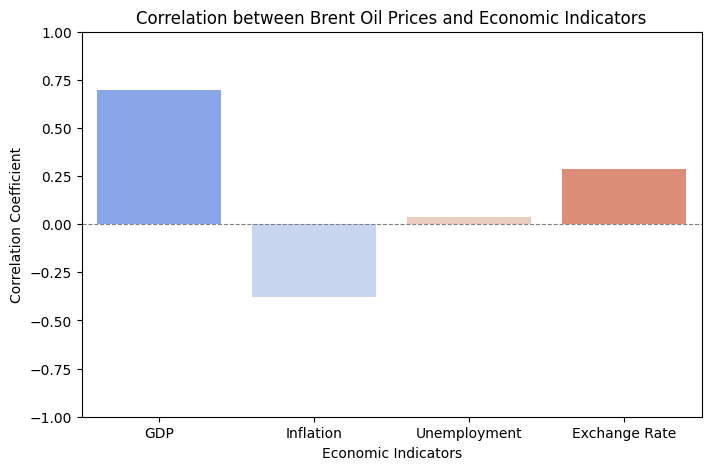

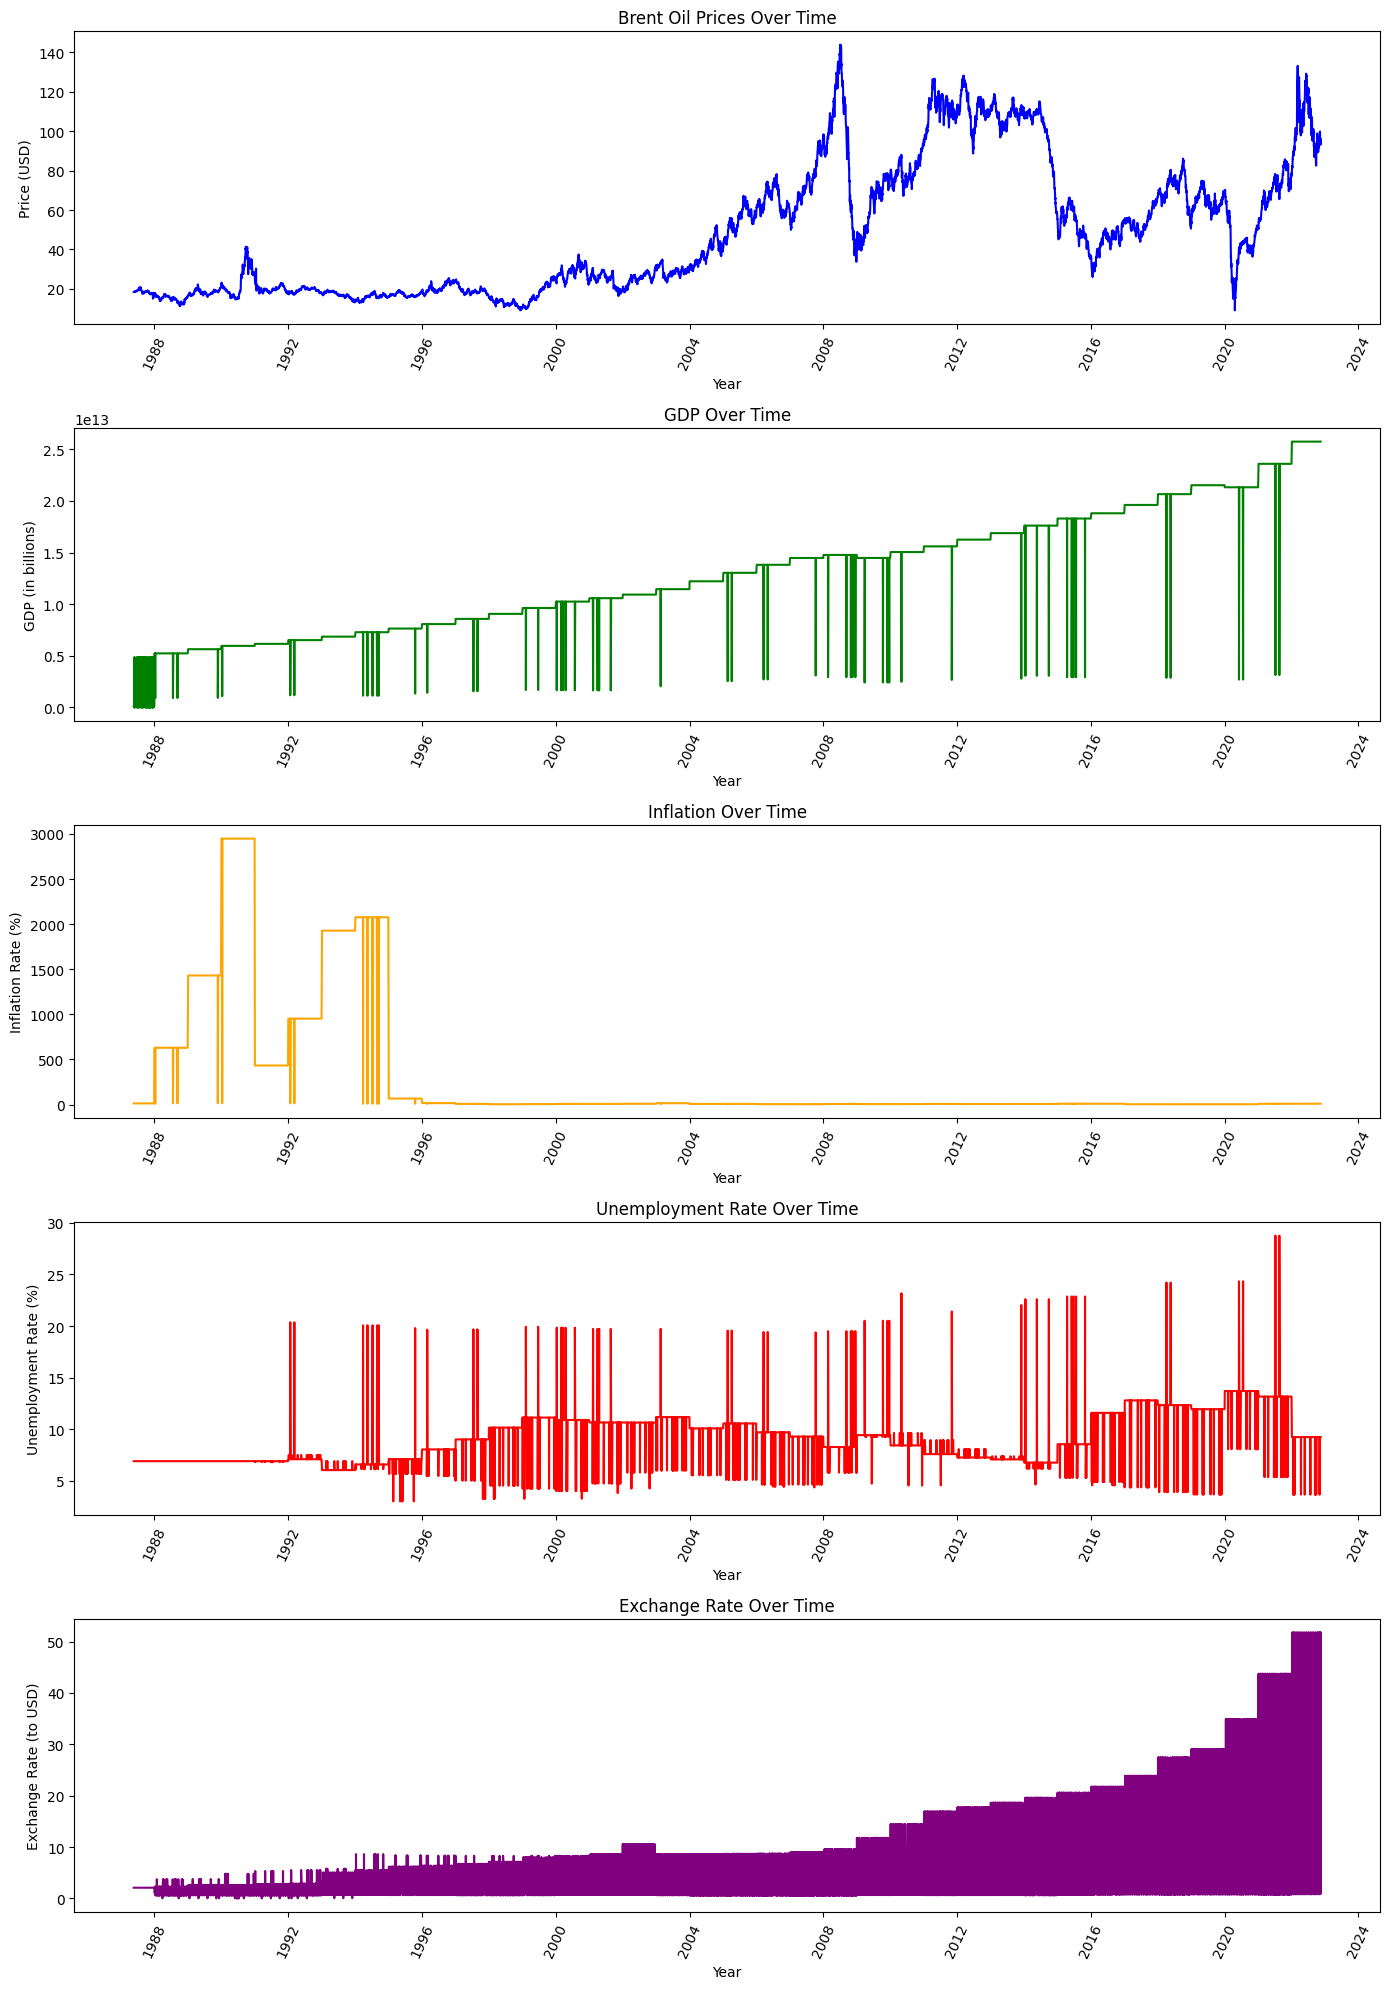

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_data already contains 'Date', 'Price', 'GDP', 'Inflation', 'Unemployment', 'Exchange Rate' columns

# Convert 'Date' column to datetime if not already done
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Calculate correlation with Brent Oil Prices for all indicators
correlations = {
    'GDP': combined_data['Price'].corr(combined_data['GDP']),
    'Inflation': combined_data['Price'].corr(combined_data['Inflation']),
    'Unemployment': combined_data['Price'].corr(combined_data['Unemployment']),
    'Exchange Rate': combined_data['Price'].corr(combined_data['Exchange Rate'])
}

# Display correlation results
for indicator, corr_value in correlations.items():
    print(f"Correlation between Brent Oil Prices and {indicator}: {corr_value:.2f}")

# Create a bar plot for the correlations
plt.figure(figsize=(8, 5))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()), palette='coolwarm')
plt.title('Correlation between Brent Oil Prices and Economic Indicators')
plt.xlabel('Economic Indicators')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')  # Add a line at y=0 for reference
plt.ylim(-1, 1)  # Set limits for y-axis
plt.show()

# Set up the figure for plotting economic indicators
fig, axs = plt.subplots(5, 1, figsize=(14, 20))  # Create subplots for each indicator

# Plotting Brent Oil Price
sns.lineplot(data=combined_data, x='Date', y='Price', color='blue', ax=axs[0])
axs[0].set_title('Brent Oil Prices Over Time')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Price (USD)')
axs[0].tick_params(axis='x', rotation=65)

# Plotting GDP Over Time
sns.lineplot(data=combined_data, x='Date', y='GDP', color='green', ax=axs[1])
axs[1].set_title('GDP Over Time')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('GDP (in billions)')
axs[1].tick_params(axis='x', rotation=65)

# Plotting Inflation Over Time
sns.lineplot(data=combined_data, x='Date', y='Inflation', color='orange', ax=axs[2])
axs[2].set_title('Inflation Over Time')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Inflation Rate (%)')
axs[2].tick_params(axis='x', rotation=65)

# Plotting Unemployment Rate Over Time
sns.lineplot(data=combined_data, x='Date', y='Unemployment', color='red', ax=axs[3])
axs[3].set_title('Unemployment Rate Over Time')
axs[3].set_xlabel('Year')
axs[3].set_ylabel('Unemployment Rate (%)')
axs[3].tick_params(axis='x', rotation=65)

# Plotting Exchange Rate Over Time
sns.lineplot(data=combined_data, x='Date', y='Exchange Rate', color='purple', ax=axs[4])
axs[4].set_title('Exchange Rate Over Time')
axs[4].set_xlabel('Year')
axs[4].set_ylabel('Exchange Rate (to USD)')
axs[4].tick_params(axis='x', rotation=65)

# Display plots for economic indicators
plt.tight_layout()
plt.show()

In [146]:
data_og = data.copy()

> # Technological Changes

In [147]:
import requests
import pandas as pd

API_KEY = 'kbOwm99mo0czWV8Xrr5NYMBUNiCM1sdw7FuRjehC'
# API URL and parameters
url = "https://api.eia.gov/v2/crude-oil-imports/data/"
params = {
    "frequency": "monthly",
    "data[0]": "quantity",
    "start": "2009-01",
    "end": "2022-08",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers to include the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()
    
    # Extract the data portion
    if 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Convert to a DataFrame
        df_oil_imports = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
        print(df_oil_imports.head())  # Show the first few rows
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")


    period originId           originName originType originTypeName  \
0  2022-08   CTY_TD  Trinidad and Tobago        CTY        Country   
1  2022-08   CTY_AO               Angola        CTY        Country   
2  2022-08   CTY_CA               Canada        CTY        Country   
3  2022-08   CTY_BR               Brazil        CTY        Country   
4  2022-08   CTY_IZ                 Iraq        CTY        Country   

  destinationId     destinationName destinationType destinationTypeName  \
0          RP_1  PADD1 (East Coast)              RP       Refinery PADD   
1       PT_1003          Newark, NJ              PT                Port   
2          RP_2     PADD2 (Midwest)              RP       Refinery PADD   
3          RP_5  PADD5 (West Coast)              RP       Refinery PADD   
4          RP_3  PADD3 (Gulf Coast)              RP       Refinery PADD   

  gradeId   gradeName quantity    quantity-units  
0     HSO  Heavy Sour      467  thousand barrels  
1     MED      Medium     

In [148]:
df_oil_imports.head()

period originId           originName originType originTypeName  \
0  2022-08   CTY_TD  Trinidad and Tobago        CTY        Country   
1  2022-08   CTY_AO               Angola        CTY        Country   
2  2022-08   CTY_CA               Canada        CTY        Country   
3  2022-08   CTY_BR               Brazil        CTY        Country   
4  2022-08   CTY_IZ                 Iraq        CTY        Country   

  destinationId     destinationName destinationType destinationTypeName  \
0          RP_1  PADD1 (East Coast)              RP       Refinery PADD   
1       PT_1003          Newark, NJ              PT                Port   
2          RP_2     PADD2 (Midwest)              RP       Refinery PADD   
3          RP_5  PADD5 (West Coast)              RP       Refinery PADD   
4          RP_3  PADD3 (Gulf Coast)              RP       Refinery PADD   

  gradeId   gradeName quantity    quantity-units  
0     HSO  Heavy Sour      467  thousand barrels  
1     MED      Medium      908  thousand barrels  
2     MED      Medium     9554  thousand barrels  
3     MED      Medium     2984  thousand barrels  
4     MED      Medium      954  thousand barrels

>> ## Renewable Energy

In [150]:
import requests
import pandas as pd

# API Key (replace with your own if different)
API_KEY = 'kbOwm99mo0czWV8Xrr5NYMBUNiCM1sdw7FuRjehC'

# API URL and parameters
url = "https://api.eia.gov/v2/steo/data/"
params = {
    "frequency": "monthly",
    "data[0]": "value",
    "facets": {},
    "start": "1987-01",
    "end": "2022-11",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers with the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Extract 'data' field from JSON, which contains the import data
    if 'response' in data and 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Create a DataFrame from the data
        renewable_energy = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")


In [151]:
renewable_energy.head()

period              seriesId  \
0  2022-11               ARTCPUS   
1  2022-11         PAPR_OPECPLUS   
2  2022-11   COPR_OPECPLUS_OTHER   
3  2022-11              WORLD_NC   
4  2022-11  COPR_NONOPECPLUS_XUS   

                                   seriesDescription         value  \
0              Asphalt and Road Oil Product Supplied       .368504   
1                       Total OPEC+ Petroleum Supply        45.477   
2                     OPEC+ Other Participants Total       15.2975   
3             World non-Crude Oil Liquids Production  24.897701533   
4  Non-OPEC+ exluding United States Crude Oil Pro...  25.946726894   

                      unit  
0  million barrels per day  
1  million barrels per day  
2  million barrels per day  
3  million barrels per day  
4  million barrels per day

>> ## Alternatives

>> ## Coal Consumption

In [152]:
import requests
import pandas as pd

# API Key (replace with your own if different)
API_KEY = 'kbOwm99mo0czWV8Xrr5NYMBUNiCM1sdw7FuRjehC'

# API URL and parameters
url = "https://api.eia.gov/v2/coal/consumption-and-quality/data/"
params = {
    "frequency": "quarterly",
    "data[0]": "ash-content",
    "data[1]": "consumption",
    "data[2]": "heat-content",
    "data[3]": "price",
    "data[4]": "receipts",
    "data[5]": "stocks",
    "data[6]": "sulfur-content",
    "facets": {},
    "start": "2000-Q1",
    "end": "2022-Q3",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers with the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Extract 'data' field from JSON, which contains the import data
    if 'response' in data and 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Create a DataFrame from the data
        coal_cons = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")


In [153]:
coal_cons.head()

period location stateDescription sector sectorDescription ash-content  \
0  2022-Q3       81  Middle Atlantic      1  Electric Utility        None   
1  2022-Q3       WY          Wyoming     98    Electric Power        7.27   
2  2022-Q3       WV    West Virginia     98    Electric Power       10.92   
3  2022-Q3       WI        Wisconsin     98    Electric Power        5.13   
4  2022-Q3       WA       Washington     98    Electric Power        8.75   

  consumption heat-content  price receipts stocks sulfur-content  \
0           0         None   None     None   None           None   
1     6261685    17.559932   None  5243039   None            .41   
2     6176330    24.740472   None  5931811   None           3.28   
3     3619609    17.877569  45.25  3430465   None            .43   
4      771067    17.093282   None   868665   None            .37   

               ash-content-units consumption-units  \
0  average ash percent by weight        short tons   
1  average ash percent by weight        short tons   
2  average ash percent by weight        short tons   
3  average ash percent by weight        short tons   
4  average ash percent by weight        short tons   

                 heat-content-units            price-units receipts-units  \
0  average sulfur percent by weight  dollars per short ton     short tons   
1  average sulfur percent by weight  dollars per short ton     short tons   
2  average sulfur percent by weight  dollars per short ton     short tons   
3  average sulfur percent by weight  dollars per short ton     short tons   
4  average sulfur percent by weight  dollars per short ton     short tons   

  stocks-units              sulfur-content-units  
0   short tons  average sulfur percent by weight  
1   short tons  average sulfur percent by weight  
2   short tons  average sulfur percent by weight  
3   short tons  average sulfur percent by weight  
4   short tons  average sulfur percent by weight

>> ## Natural Gas

In [154]:
import requests
import pandas as pd

# API Key (replace with your own if different)
API_KEY = 'kbOwm99mo0czWV8Xrr5NYMBUNiCM1sdw7FuRjehC'

# API URL and parameters
url = "https://api.eia.gov/v2/natural-gas/pri/rescom/data/"
params = {
    "frequency": "monthly",
    "data[0]": "value",
    "facets": {},
    "start": "1989-01",
    "end": "2022-08",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers with the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Extract 'data' field from JSON, which contains the import data
    if 'response' in data and 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Create a DataFrame from the data
        natural_gas = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")


In [155]:
natural_gas.head()

period duoarea area-name product product-name process  \
0  2022-07     SDC    USA-DC    EPG0  Natural Gas     PCS   
1  2022-07     SOH      OHIO    EPG0  Natural Gas     PRS   
2  2022-07     SNJ    USA-NJ    EPG0  Natural Gas     PCS   
3  2022-07     SGA    USA-GA    EPG0  Natural Gas     PCS   
4  2022-07     SNJ    USA-NJ    EPG0  Natural Gas     PRS   

                               process-name    series  \
0     Price Delivered to Commercial Sectors  N3020DC3   
1  Price Delivered to Residential Consumers  N3010OH3   
2     Price Delivered to Commercial Sectors  N3020NJ3   
3     Price Delivered to Commercial Sectors  N3020GA3   
4  Price Delivered to Residential Consumers  N3010NJ3   

                                  series-description  value  units  
0  District of Columbia Price of Natural Gas Sold...  18.05  $/MCF  
1  Ohio Price of Natural Gas Delivered to Residen...  36.92  $/MCF  
2  New Jersey Price of Natural Gas Sold to Commer...  14.85  $/MCF  
3  Georgia Price of Natural Gas Sold to Commercia...   14.3  $/MCF  
4  New Jersey Price of Natural Gas Delivered to R...  16.31  $/MCF

In [156]:
data_og.head()

Date  Price  year  price_diff
0 1987-05-21  18.45  1987       -0.18
1 1987-05-22  18.55  1987        0.10
2 1987-05-25  18.60  1987        0.05
3 1987-05-26  18.63  1987        0.03
4 1987-05-27  18.60  1987       -0.03

In [157]:
import pandas as pd

data_og['Date'] = pd.to_datetime(data_og['Date'])
natural_gas['period'] = pd.to_datetime(natural_gas['period'])
coal_cons['period'] = pd.to_datetime(coal_cons['period'])
renewable_energy['period'] = pd.to_datetime(renewable_energy['period'])
df_oil_imports['period'] = pd.to_datetime(df_oil_imports['period'])

/tmp/ipykernel_4717/3439675368.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coal_cons['period'] = pd.to_datetime(coal_cons['period'])


In [158]:
natural_gas = natural_gas[['period', 'area-name', 'product-name', 'series-description', 'value', 'units']]
coal_consumption = coal_cons[['period', 'location', 'sectorDescription', 'consumption', 'price', 'consumption-units', 'price-units']]
renewable_energy = renewable_energy[['period', 'seriesDescription', 'value', 'unit']]
df_oil_imports = df_oil_imports[['period', 'originName', 'gradeName', 'quantity', 'quantity-units']]

In [159]:
data_og = data_og.reset_index()
natural_gas = natural_gas.reset_index()
coal_consumption = coal_consumption.reset_index()
renewable_energy = renewable_energy.reset_index()
df_oil_imports = df_oil_imports.reset_index()

In [160]:
data_og.set_index('Date', inplace=True)
natural_gas.set_index('period', inplace=True)
coal_consumption.set_index('period', inplace=True)
renewable_energy.set_index('period', inplace=True)
df_oil_imports.set_index('period', inplace=True)

In [161]:
print(natural_gas.dtypes)
print(coal_consumption.dtypes)
print(renewable_energy.dtypes)
print(df_oil_imports.dtypes)


index                  int64
area-name             object
product-name          object
series-description    object
value                 object
units                 object
dtype: object
index                 int64
location             object
sectorDescription    object
consumption          object
price                object
consumption-units    object
price-units          object
dtype: object
index                 int64
seriesDescription    object
value                object
unit                 object
dtype: object
index              int64
originName        object
gradeName         object
quantity          object
quantity-units    object
dtype: object


In [177]:
natural_gas['value'] = pd.to_numeric(natural_gas['value'], errors='coerce')
coal_consumption['consumption'] = pd.to_numeric(coal_consumption['consumption'], errors='coerce')
renewable_energy['value'] = pd.to_numeric(renewable_energy['value'], errors='coerce')
df_oil_imports['quantity'] = pd.to_numeric(df_oil_imports['quantity'], errors='coerce')

natural_gas['value_x'] = natural_gas['value'].fillna(natural_gas['value'].median())
coal_consumption['consumption'] = coal_consumption['consumption'].fillna(coal_consumption['consumption'].median())
renewable_energy['value_y'] = renewable_energy['value'].fillna(renewable_energy['value'].median())
df_oil_imports['quantity'] = df_oil_imports['quantity'].fillna(df_oil_imports['quantity'].median())


natural_gas_monthly = natural_gas.resample('M').mean(numeric_only=True)
coal_consumption_monthly = coal_consumption.resample('M').sum(numeric_only=True)
renewable_energy_monthly = renewable_energy.resample('M').sum(numeric_only=True)
oil_imports_monthly = df_oil_imports.resample('M').sum(numeric_only=True)

/tmp/ipykernel_4717/183594467.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  natural_gas_monthly = natural_gas.resample('M').mean(numeric_only=True)
/tmp/ipykernel_4717/183594467.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  coal_consumption_monthly = coal_consumption.resample('M').sum(numeric_only=True)
/tmp/ipykernel_4717/183594467.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  renewable_energy_monthly = renewable_energy.resample('M').sum(numeric_only=True)
/tmp/ipykernel_4717/183594467.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  oil_imports_monthly = df_oil_imports.resample('M').sum(numeric_only=True)


In [178]:
common_date_range = pd.date_range(start='2009-01', end='2022-08', freq='M')

/tmp/ipykernel_4717/2359085098.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  common_date_range = pd.date_range(start='2009-01', end='2022-08', freq='M')


In [179]:
data_og = data_og.reindex(common_date_range)
natural_gas_monthly = natural_gas_monthly.reindex(common_date_range)
coal_consumption_monthly = coal_consumption_monthly.reindex(common_date_range)
renewable_energy_monthly = renewable_energy_monthly.reindex(common_date_range)
oil_imports_monthly = oil_imports_monthly.reindex(common_date_range)


In [180]:
data_og.fillna(method='ffill', inplace=True)
natural_gas_monthly.fillna(method='ffill', inplace=True)
coal_consumption_monthly.fillna(method='ffill', inplace=True)
renewable_energy_monthly.fillna(method='ffill', inplace=True)
oil_imports_monthly.fillna(method='ffill', inplace=True)


/tmp/ipykernel_4717/3986204348.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_og.fillna(method='ffill', inplace=True)
/tmp/ipykernel_4717/3986204348.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  natural_gas_monthly.fillna(method='ffill', inplace=True)
/tmp/ipykernel_4717/3986204348.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coal_consumption_monthly.fillna(method='ffill', inplace=True)
/tmp/ipykernel_4717/3986204348.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  renewable_energy_monthly.fillna(method='ffill', inplace=True)
/tmp/ipykernel_4717/3986204348.py:5: FutureWarning: DataFrame.fillna with 

In [181]:
coal_consumption.head()

index location sectorDescription  consumption  price  \
period                                                             
2022-07-01      0       81  Electric Utility          0.0   None   
2022-07-01      1       WY    Electric Power    6261685.0   None   
2022-07-01      2       WV    Electric Power    6176330.0   None   
2022-07-01      3       WI    Electric Power    3619609.0  45.25   
2022-07-01      4       WA    Electric Power     771067.0   None   

           consumption-units            price-units  
period                                               
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton

In [182]:
combined_df = pd.concat([data_og, natural_gas_monthly, coal_consumption_monthly, renewable_energy_monthly, oil_imports_monthly], axis=1)

In [183]:
combined_df.columns

Index(['index', 'Price', 'year', 'price_diff', 'index', 'value', 'value_x',
       'index', 'consumption', 'index', 'value', 'value_y', 'index',
       'quantity'],
      dtype='object')

In [184]:
combined_df.rename(columns={
    'Price': 'Oil_Price',
    'value_x': 'Natural_Gas_Value',
    'consumption': 'Coal_Consumption',
    'value_y': 'Renewable_Energy_Value',
    'quantity': 'Oil_Imports_Quantity'
}, inplace=True)


In [185]:
combined_df['Oil_Price_Diff'] = combined_df['Oil_Price'].pct_change() * 100


In [186]:
print(combined_df.columns)


Index(['index', 'Oil_Price', 'year', 'price_diff', 'index', 'value',
       'Natural_Gas_Value', 'index', 'Coal_Consumption', 'index', 'value',
       'Renewable_Energy_Value', 'index', 'Oil_Imports_Quantity',
       'Oil_Price_Diff'],
      dtype='object')


In [187]:
combined_df['Natural_Gas_Rolling'] = combined_df.get('Natural_Gas_Value', pd.Series()).rolling(window=3).mean()


In [188]:
correlation_matrix = combined_df.corr()
oil_price_correlation = correlation_matrix['Oil_Price']


In [193]:
combined_df.head(0)

Empty DataFrame
Columns: [index, Oil_Price, year, price_diff, index, value, Natural_Gas_Value, index, Coal_Consumption, index, value, Renewable_Energy_Value, index, Oil_Imports_Quantity, Oil_Price_Diff, Natural_Gas_Rolling]
Index: []

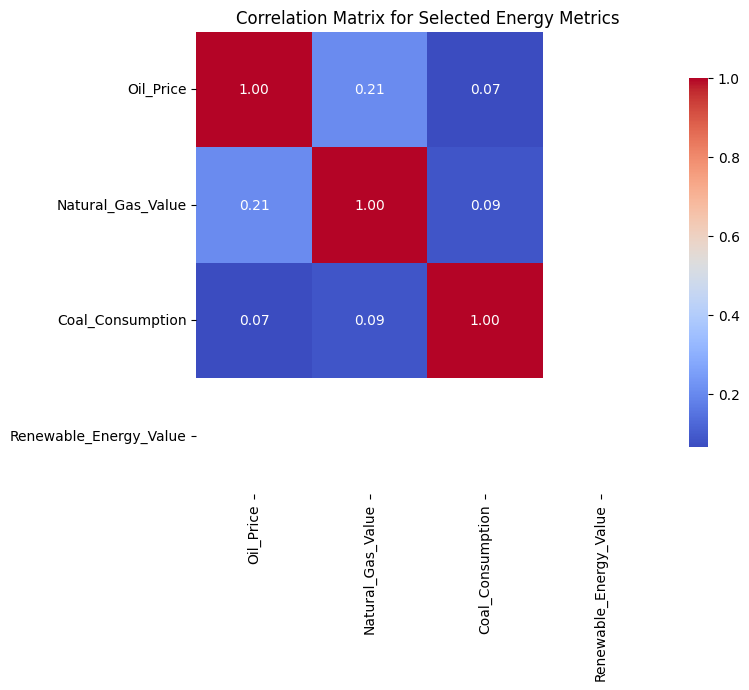

In [198]:
columns_of_interest = ['Oil_Price', 'Natural_Gas_Value', 'Coal_Consumption', 'Renewable_Energy_Value']
correlation_matrix = combined_df[columns_of_interest].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix for Selected Energy Metrics')
plt.show()

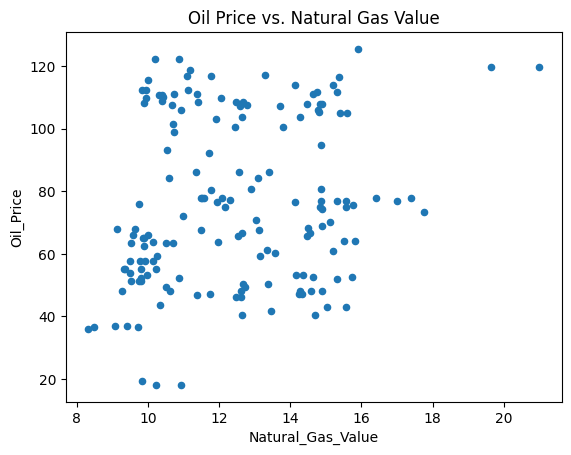

In [190]:
combined_df.plot(kind='scatter', x='Natural_Gas_Value', y='Oil_Price', title='Oil Price vs. Natural Gas Value')
plt.show()


>>> ### Data Preprocess

In [ ]:
print(combined_data.isna().sum())

combined_data[['GDP', 'Unemployment']] = combined_data[['GDP', 'Unemployment']].fillna(
    combined_data[['GDP', 'Unemployment']].median()
)

print(combined_data.isna().sum())

combined_data.head(40)

Date                0
Price               0
year                0
price_diff          1
country          9010
GDP              9011
Inflation        9010
Unemployment     9034
Exchange Rate    9010
dtype: int64
Date                0
Price               0
year                0
price_diff          1
country          9010
GDP                 0
Inflation        9010
Unemployment        0
Exchange Rate    9010
dtype: int64


Date  Price    year  price_diff country           GDP  Inflation  \
0  1987-05-20  18.63  1987.0         NaN     NaN  1.107627e+12        NaN   
1  1987-05-21  18.45  1987.0       -0.18     NaN  1.107627e+12        NaN   
2  1987-05-22  18.55  1987.0        0.10     NaN  1.107627e+12        NaN   
3  1987-05-25  18.60  1987.0        0.05     NaN  1.107627e+12        NaN   
4  1987-05-26  18.63  1987.0        0.03     NaN  1.107627e+12        NaN   
5  1987-05-27  18.60  1987.0       -0.03     NaN  1.107627e+12        NaN   
6  1987-05-28  18.60  1987.0        0.00     NaN  1.107627e+12        NaN   
7  1987-05-29  18.58  1987.0       -0.02     NaN  1.107627e+12        NaN   
8  1987-06-01  18.65  1987.0        0.07     NaN  1.107627e+12        NaN   
9  1987-06-02  18.68  1987.0        0.03     NaN  1.107627e+12        NaN   
10 1987-06-03  18.75  1987.0        0.07     NaN  1.107627e+12        NaN   
11 1987-06-04  18.78  1987.0        0.03     NaN  1.107627e+12        NaN   
12 1987-06-05  18.65  1987.0       -0.13     NaN  1.107627e+12        NaN   
13 1987-06-08  18.75  1987.0        0.10     NaN  1.107627e+12        NaN   
14 1987-06-09  18.78  1987.0        0.03     NaN  1.107627e+12        NaN   
15 1987-06-10  18.78  1987.0        0.00     NaN  1.107627e+12        NaN   
16 1987-06-11  18.68  1987.0       -0.10     NaN  1.107627e+12        NaN   
17 1987-06-12  18.78  1987.0        0.10     NaN  1.107627e+12        NaN   
18 1987-06-16  18.90  1987.0        0.12     NaN  1.107627e+12        NaN   
19 1987-06-17  19.03  1987.0        0.13     NaN  1.107627e+12        NaN   
20 1987-06-18  19.05  1987.0        0.02     NaN  1.107627e+12        NaN   
21 1987-06-19  19.05  1987.0        0.00     NaN  1.107627e+12        NaN   
22 1987-06-22  19.10  1987.0        0.05     NaN  1.107627e+12        NaN   
23 1987-06-23  18.90  1987.0       -0.20     NaN  1.107627e+12        NaN   
24 1987-06-24  18.75  1987.0       -0.15     NaN  1.107627e+12        NaN   
25 1987-06-25  18.70  1987.0       -0.05     NaN  1.107627e+12        NaN   
26 1987-06-26  19.08  1987.0        0.38     NaN  1.107627e+12        NaN   
27 1987-06-29  19.15  1987.0        0.07     NaN  1.107627e+12        NaN   
28 1987-06-30  19.08  1987.0       -0.07     NaN  1.107627e+12        NaN   
29 1987-07-01  18.98  1987.0       -0.10     NaN  1.107627e+12        NaN   
30 1987-07-02  19.25  1987.0        0.27     NaN  1.107627e+12        NaN   
31 1987-07-03  19.33  1987.0        0.08     NaN  1.107627e+12        NaN   
32 1987-07-06  19.48  1987.0        0.15     NaN  1.107627e+12        NaN   
33 1987-07-07  19.50  1987.0        0.02     NaN  1.107627e+12        NaN   
34 1987-07-08  19.48  1987.0       -0.02     NaN  1.107627e+12        NaN   
35 1987-07-09  19.68  1987.0        0.20     NaN  1.107627e+12        NaN   
36 1987-07-10  19.73  1987.0        0.05     NaN  1.107627e+12        NaN   
37 1987-07-13  19.83  1987.0        0.10     NaN  1.107627e+12        NaN   
38 1987-07-14  19.88  1987.0        0.05     NaN  1.107627e+12        NaN   
39 1987-07-15  20.28  1987.0        0.40     NaN  1.107627e+12        NaN   

    Unemployment  Exchange Rate  
0         5.5435            NaN  
1         5.5435            NaN  
2         5.5435            NaN  
3         5.5435            NaN  
4         5.5435            NaN  
5         5.5435            NaN  
6         5.5435            NaN  
7         5.5435            NaN  
8         5.5435            NaN  
9         5.5435            NaN  
10        5.5435            NaN  
11        5.5435            NaN  
12        5.5435            NaN  
13        5.5435            NaN  
14        5.5435            NaN  
15        5.5435            NaN  
16        5.5435            NaN  
17        5.5435            NaN  
18        5.5435            NaN  
19        5.5435            NaN  
20        5.5435            NaN  
21        5.5435            NaN  
22        5.5435            NaN  
23        5.5435            NaN  
2

>>> ### EDA

In [ ]:
combined_data.head()

Date  Price  price_diff           GDP   Inflation  Unemployment  \
0  1987-05-20  18.63       -0.18  9.653576e+10  629.114509         6.896   
6  1987-05-21  18.45       -0.18  9.653576e+10  629.114509         6.896   
17 1987-05-22  18.55        0.10  9.653576e+10  629.114509         6.896   
18 1987-05-25  18.60        0.05  1.079000e+10  629.114509         6.896   
28 1987-05-26  18.63        0.03  4.855215e+12  629.114509         6.896   

    Exchange Rate  Inflation_missing  Unemployment_missing  \
0    1.135477e-07                  1                     1   
6    1.135477e-07                  1                     1   
17   1.135477e-07                  1                     1   
18   1.135477e-07                  1                     1   
28   1.135477e-07                  1                     1   

    Exchange Rate_missing  
0                       1  
6                       1  
17                      1  
18                      1  
28                      1

>> ## VAR for Multivariate Analysis

In [ ]:
combined_data.head()

Date  Price  price_diff           GDP   Inflation  Unemployment  \
0  1987-05-20  18.63       -0.18  9.653576e+10  629.114509         6.896   
6  1987-05-21  18.45       -0.18  9.653576e+10  629.114509         6.896   
17 1987-05-22  18.55        0.10  9.653576e+10  629.114509         6.896   
18 1987-05-25  18.60        0.05  1.079000e+10  629.114509         6.896   
28 1987-05-26  18.63        0.03  4.855215e+12  629.114509         6.896   

    Exchange Rate  Inflation_missing  Unemployment_missing  \
0    1.135477e-07                  1                     1   
6    1.135477e-07                  1                     1   
17   1.135477e-07                  1                     1   
18   1.135477e-07                  1                     1   
28   1.135477e-07                  1                     1   

    Exchange Rate_missing  
0                       1  
6                       1  
17                      1  
18                      1  
28                      1

/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Nov, 2024
Time:                     12:05:10
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    69.9259
Nobs:                     9009.00    HQIC:                   69.9103
Log likelihood:          -378761.    FPE:                2.28111e+30
AIC:                      69.9022    Det(Omega_mle):     2.27353e+30
--------------------------------------------------------------------
Results for equation Price
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.008177         0.012812            0.638           0.523
L1.Price                 0.025630         0.010541            2.432           0.015
L1.GDP                  -0.000000         0.0000

/tmp/ipykernel_8338/466758269.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


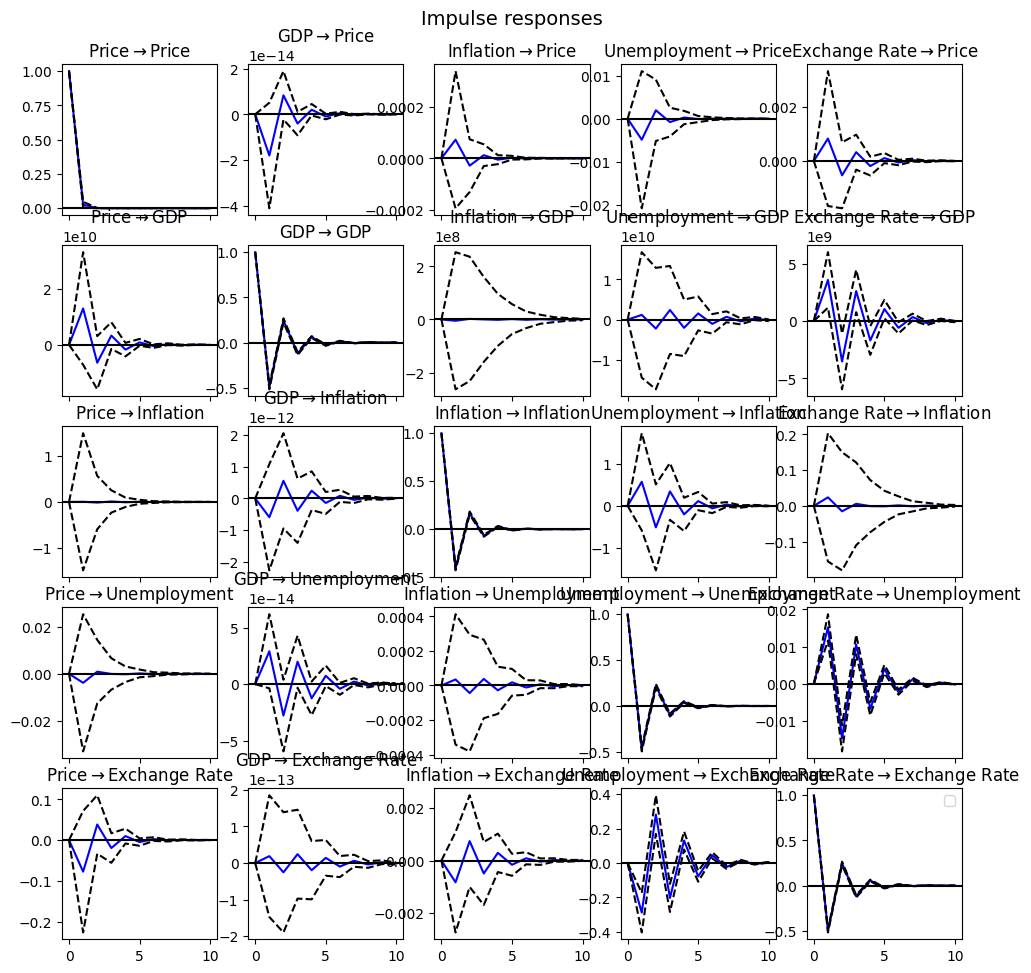

In [ ]:
data_multivariate = combined_data[['Price', 'GDP', 'Inflation','Unemployment','Exchange Rate']]

data_diff = data_multivariate.diff().dropna()

from statsmodels.tsa.api import VAR
model = VAR(data_diff)
var_model = model.fit()
print(var_model.summary())

forecast = var_model.forecast(data_diff.values[-var_model.k_ar:], steps=10)
to_be_plotted = var_model.irf(10)
to_be_plotted.plot(orth=False)
# plt.plot(to_be_plotted, label='VAR Forecast')
plt.legend()
plt.show()


/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


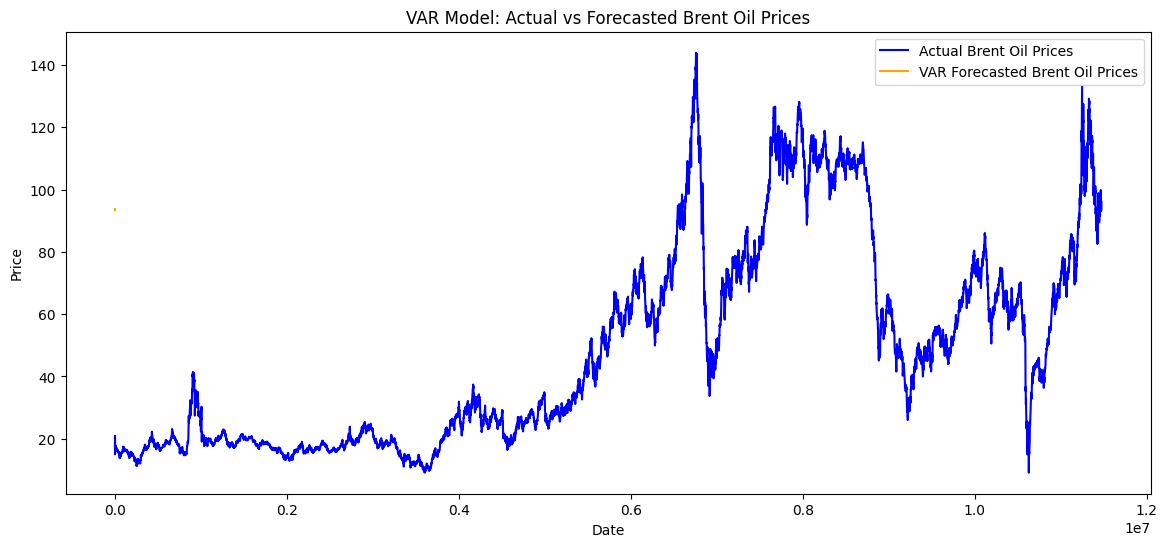

In [ ]:
from statsmodels.tsa.api import VAR

# Prepare data for VAR model
model_data = combined_data[['Price', 'GDP', 'Inflation', 'Unemployment']].dropna()
model = VAR(model_data)
model_fitted = model.fit(4)

# Forecasting
forecast = model_fitted.forecast(model_data.values[-4:], steps=10)  # Forecast next 10 steps
forecast_df = pd.DataFrame(forecast, columns=model_data.columns)

# Plot actual vs forecasted values for Brent oil price
plt.figure(figsize=(14, 6))
plt.plot(model_data.index, model_data['Price'], label='Actual Brent Oil Prices', color="blue")
plt.plot(forecast_df.index, forecast_df['Price'], label='VAR Forecasted Brent Oil Prices', color="orange")
plt.title('VAR Model: Actual vs Forecasted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


>> ## Markov-Switching model

/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


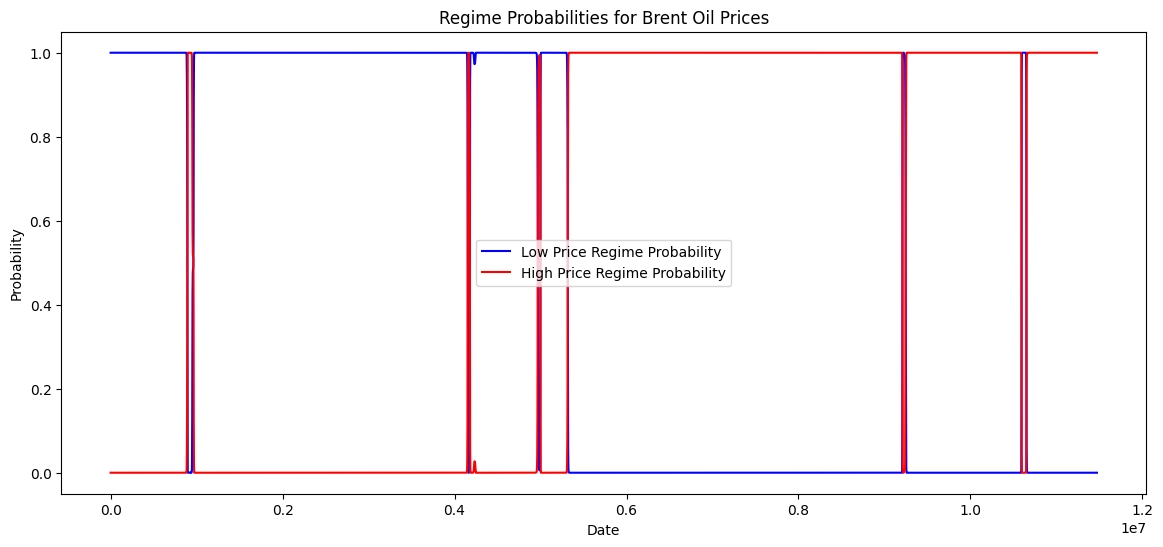

In [ ]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit Markov Switching Model
markov_model = MarkovRegression(combined_data['Price'].dropna(), k_regimes=2, trend='c', switching_variance=True)
markov_fitted = markov_model.fit()

# Plot smoothed probabilities of regimes
plt.figure(figsize=(14, 6))
plt.plot(markov_fitted.smoothed_marginal_probabilities[0], label='Low Price Regime Probability', color='blue')
plt.plot(markov_fitted.smoothed_marginal_probabilities[1], label='High Price Regime Probability', color='red')
plt.title('Regime Probabilities for Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.show()


>> ## LSTM

Epoch 1/10


/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0138
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 5.1839e-04
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 4.2747e-04
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 3.5748e-04
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 2.9905e-04
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 2.5584e-04
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 2.6893e-04
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 2.1903e-04
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 2.4728e-04
Epoch 10/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 1.9201e-04
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


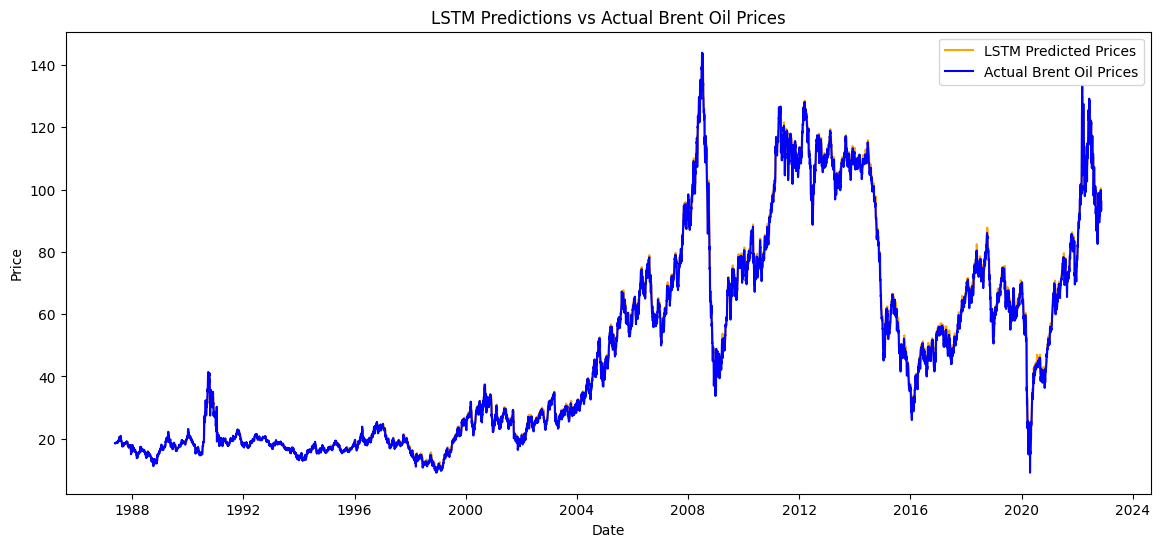

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[['Price', 'GDP', 'Inflation', 'Unemployment','Exchange Rate']].dropna())

# Prepare data for LSTM
X, y = [], []
time_steps = 60  # Sequence length

for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data[i-time_steps:i])
    y.append(scaled_data[i, 0])  

X, y = np.array(X), np.array(y)

# Define and train LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)

# Make predictions
# Make predictions
predicted_prices = model.predict(X)

# Create an array with the correct shape for inverse transformation
predicted_prices_full = np.zeros((predicted_prices.shape[0], 5))  # 5 features
predicted_prices_full[:, 0] = predicted_prices.flatten()  # Fill the first column with predicted prices

# Inverse transform
predicted_prices_full = scaler.inverse_transform(predicted_prices_full)[:, 0]  # Get only the first column

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(combined_data['Date'][-len(predicted_prices):], predicted_prices_full, label='LSTM Predicted Prices', color="orange")
plt.plot(combined_data['Date'], combined_data['Price'], label='Actual Brent Oil Prices', color="blue")
plt.title('LSTM Predictions vs Actual Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


>> ## Model Evaluation and Performance Metrics

LSTM Model RMSE: 58.30690616421228
LSTM Model MAE: 48.31774785415758


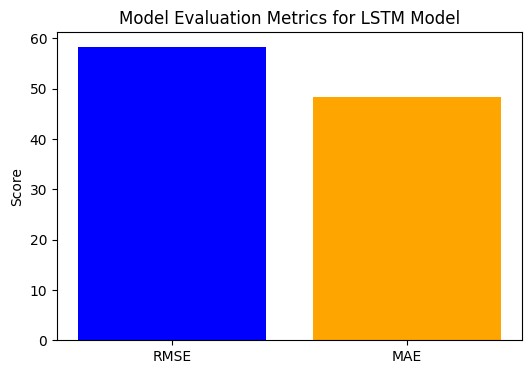

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE for LSTM model
rmse = np.sqrt(mean_squared_error(combined_data['Price'][-len(predicted_prices):], predicted_prices))
mae = mean_absolute_error(combined_data['Price'][-len(predicted_prices):], predicted_prices)

print(f"LSTM Model RMSE: {rmse}")
print(f"LSTM Model MAE: {mae}")

# Bar plot for evaluation metrics
metrics = {'RMSE': rmse, 'MAE': mae}
plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange'])
plt.title('Model Evaluation Metrics for LSTM Model')
plt.ylabel('Score')
plt.show()



>> ## Insight Generation and Analysis

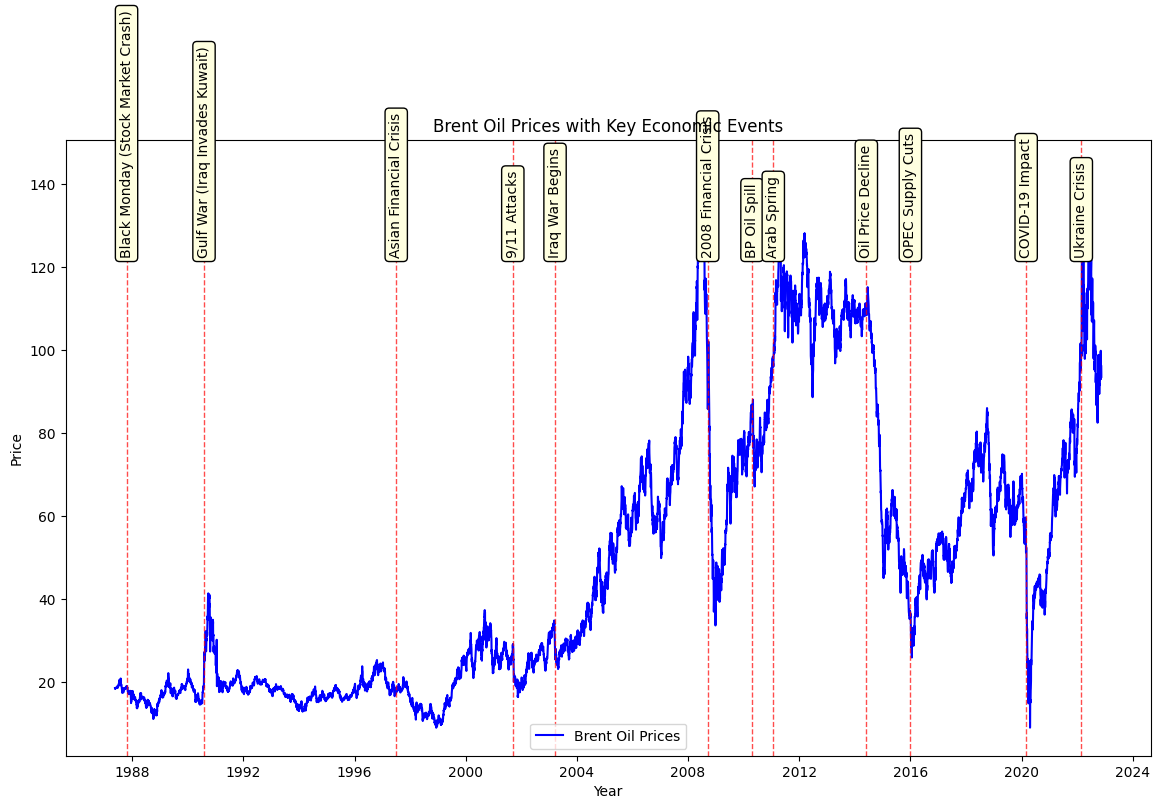

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data for the events we want to annotate
events = {
    '1987-10-19': 'Black Monday (Stock Market Crash)',
    '1990-08-02': 'Gulf War (Iraq Invades Kuwait)',
    '1997-07-02': 'Asian Financial Crisis',
    '2001-09-11': '9/11 Attacks',
    '2003-03-20': 'Iraq War Begins',
    '2008-09-15': '2008 Financial Crisis',
    '2010-04-20': 'BP Oil Spill',
    '2011-01-25': 'Arab Spring',
    '2014-06-01': 'Oil Price Decline',
    '2016-01-01': 'OPEC Supply Cuts',
    '2020-03-01': 'COVID-19 Impact',
    '2022-02-24': 'Ukraine Crisis'
}

# Plotting the Brent oil prices with annotated events
plt.figure(figsize=(14, 8))
plt.plot(combined_data['Date'], combined_data['Price'], label='Brent Oil Prices', color='blue')

# Loop over each event in the dictionary and plot it with a vertical line and annotation
for date, label in events.items():
    plt.axvline(x=pd.to_datetime(date), color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.annotate(label, 
                 xy=(pd.to_datetime(date), combined_data['Price'].max() * 0.8), 
                 xytext=(pd.to_datetime(date), combined_data['Price'].max() * 0.85),
                 rotation=90, color='black', 
                 ha='center', va='bottom', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow"))

# Adding labels and title
plt.title('Brent Oil Prices with Key Economic Events')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()


>> ## Back Testing and Validation

/home/amanuel/Documents/Ten-Academy/week10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


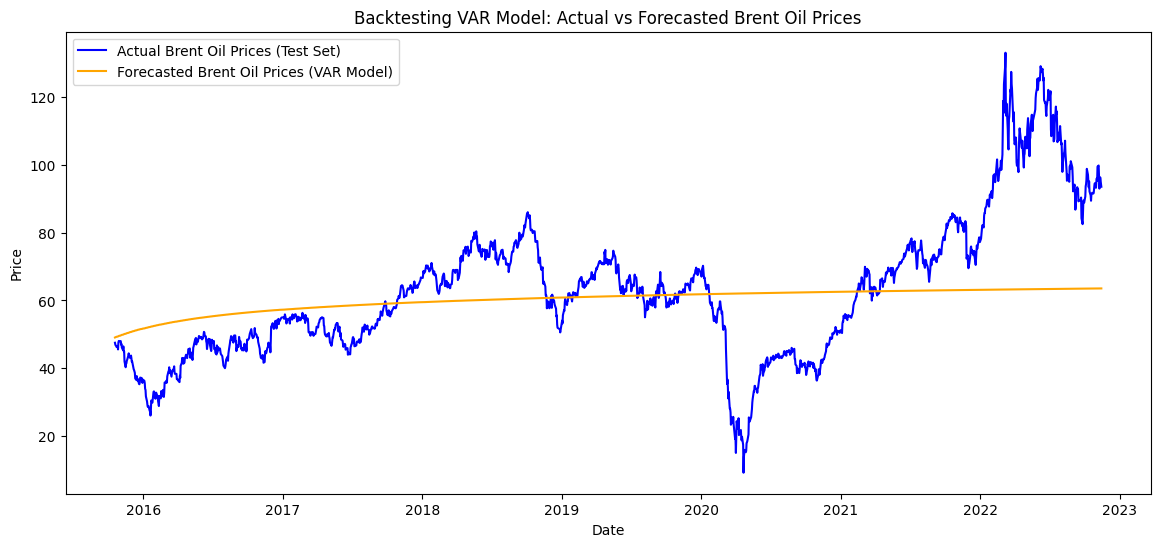

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Check and align date indexing for model_data and combined_data
model_data.index = pd.to_datetime(combined_data['Date'])
train_size = int(len(model_data) * 0.8)
train, test = model_data.iloc[:train_size], model_data.iloc[train_size:]

# Fit VAR model on training data
var_model = VAR(train)
var_model_fitted = var_model.fit(4)

# Forecast on the test set
forecasted_values = var_model_fitted.forecast(train.values[-4:], steps=len(test))

# Use the dates from the test set in combined_data to set the forecasted_df index
forecasted_df = pd.DataFrame(forecasted_values, columns=test.columns)
forecasted_df.index = test.index  # Ensure forecast aligns with test dates

# Plotting test set vs forecasted values
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['Price'], label='Actual Brent Oil Prices (Test Set)', color="blue")
plt.plot(forecasted_df.index, forecasted_df['Price'], label='Forecasted Brent Oil Prices (VAR Model)', color="orange")
plt.title('Backtesting VAR Model: Actual vs Forecasted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
